## Data Ingestion & Preprocessing (with Pathlib)

In this section, we use Python’s `pathlib.Path` to construct file paths for each log dataset. This approach is robust and works across different operating systems.  
- `base_path` points to the root directory containing all raw log datasets.
- For each dataset, we define the full path to its main log file (e.g., `hdfs.log`, `Apache.log`).
- We use the `chardet` library to detect file encoding, ensuring compatibility with logs from different systems.
- We read each log file, strip whitespace, and skip empty lines.
- For demonstration, we print the first 5 lines of each log file to preview the data structure and content.

In [67]:
from pathlib import Path
import chardet

# Set the base path to the raw log datasets directory
base_path = Path('../datasets/raw_drift_dataset')

# Define the full path to each log file
hdfs_path = base_path / 'HDFS' / 'hdfs.log'
apache_path = base_path / 'Apache' / 'Apache.log'
health_path = base_path / 'HealthApp' / 'HealthApp.log'
bgl_path = base_path / 'BGL' / 'BGL.log'
hpc_path = base_path / 'HPC' / 'HPC.log'
linux_path = base_path / 'Linux' / 'Linux.log'
mac_path = base_path / 'Mac' / 'Mac.log'

def detect_encoding(file_path):
    """
    Detect the encoding of a file using chardet.
    """
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(10000))
    return result['encoding']

def read_log_file(file_path):
    """
    Read a log file line by line, using the detected encoding.
    Strips whitespace and skips empty lines.
    Returns a list of log entries (strings).
    """
    encoding = detect_encoding(file_path)
    with open(file_path, 'r', encoding=encoding, errors='replace') as f:
        lines = [line.strip() for line in f if line.strip()]
    return lines

# Preview the first 5 lines from each log file
for name, path in [
    ("HDFS", hdfs_path),
    ("Apache", apache_path),
    ("HealthApp", health_path),
    ("BGL", bgl_path),
    ("HPC", hpc_path),
    ("Linux", linux_path),
    ("Mac", mac_path)
]:
    if path.exists():
        print(f"\n{name} sample entries from {path.name}:")
        sample_lines = read_log_file(path)[:5]  # First 5 non-empty lines
        for line in sample_lines:
            print("-", line)
    else:
        print(f"\n{name} log file not found at {path}")


HDFS sample entries from hdfs.log:
- 081109 203615 148 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_38865049064139660 terminating
- 081109 203807 222 INFO dfs.DataNode$PacketResponder: PacketResponder 0 for block blk_-6952295868487656571 terminating
- 081109 204005 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.73.220:50010 is added to blk_7128370237687728475 size 67108864
- 081109 204015 308 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_8229193803249955061 terminating
- 081109 204106 329 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-6670958622368987959 terminating

Apache sample entries from Apache.log:
- [Thu Jun 09 06:07:04 2005] [notice] LDAP: Built with OpenLDAP LDAP SDK
- [Thu Jun 09 06:07:04 2005] [notice] LDAP: SSL support unavailable
- [Thu Jun 09 06:07:04 2005] [notice] suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)
- [Thu Jun 09 06:07:05 2005] [notice] Digest: genera

## Data Exploration & Cleaning

In this section, we perform an in-depth exploration and cleaning of each log dataset.  
We will:
- Examine entry structure and length distributions
- Identify and handle missing or malformed entries
- Analyze message types and their frequencies
- Explore timestamp formats and temporal coverage
- Investigate component diversity and frequency
- Visualize key properties for each dataset

This comprehensive analysis will validate our earlier claims and guide robust feature engineering.

### Entry Structure & Length Analysis

In this step, we analyze the structure and length of log entries for each dataset.  
- We compute statistics such as the total number of entries, minimum, maximum, mean, and standard deviation of entry lengths.
- Visualizing the distribution of entry lengths helps us understand the variability and typical size of log messages.
- This analysis can reveal outliers, unusually short or long entries, and inform later parsing and feature extraction.


APACHE Log Entry Lengths:
  Total entries: 56482
  Min length: 34
  Max length: 187
  Mean length: 89.93
  Std dev: 21.66


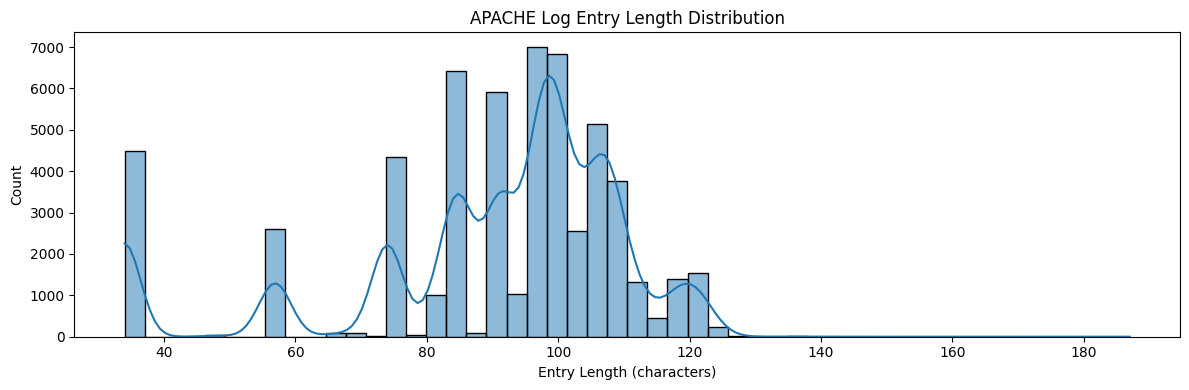


HDFS Log Entry Lengths:
  Total entries: 2000
  Min length: 93
  Max length: 2520
  Mean length: 141.92
  Std dev: 76.99


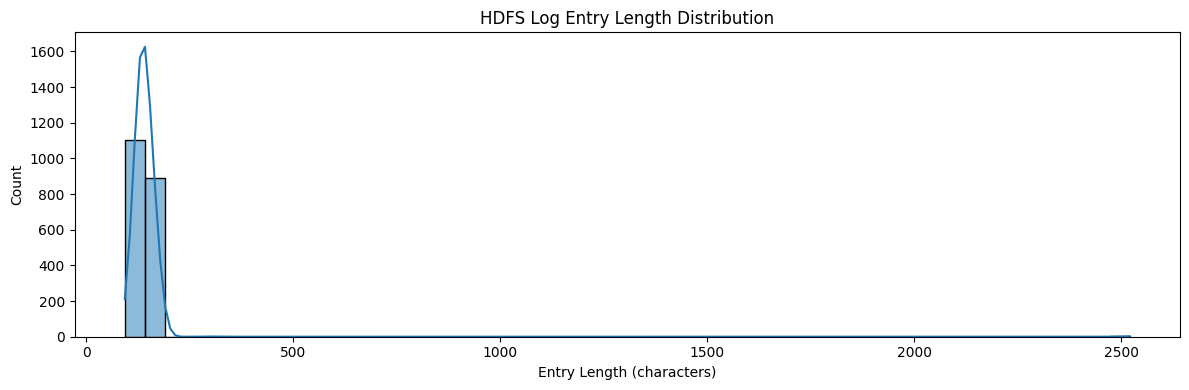


BGL Log Entry Lengths:
  Total entries: 4747963
  Min length: 94
  Max length: 928
  Mean length: 155.53
  Std dev: 50.28


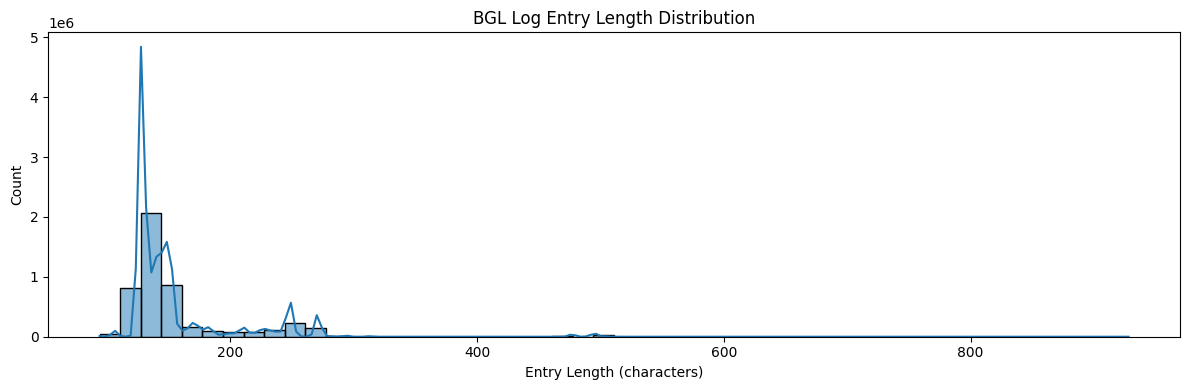


HEALTHAPP Log Entry Lengths:
  Total entries: 253395
  Min length: 48
  Max length: 294
  Mean length: 90.86
  Std dev: 22.49


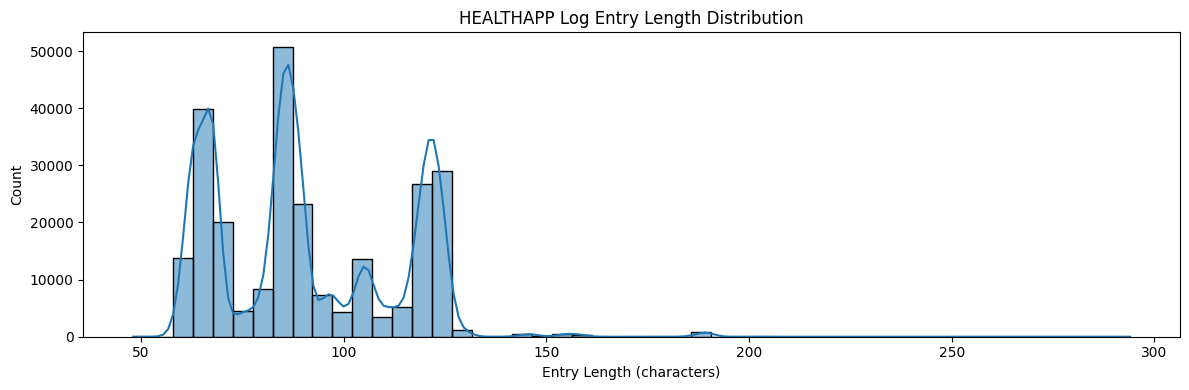


HPC Log Entry Lengths:
  Total entries: 433490
  Min length: 43
  Max length: 895
  Mean length: 75.40
  Std dev: 34.38


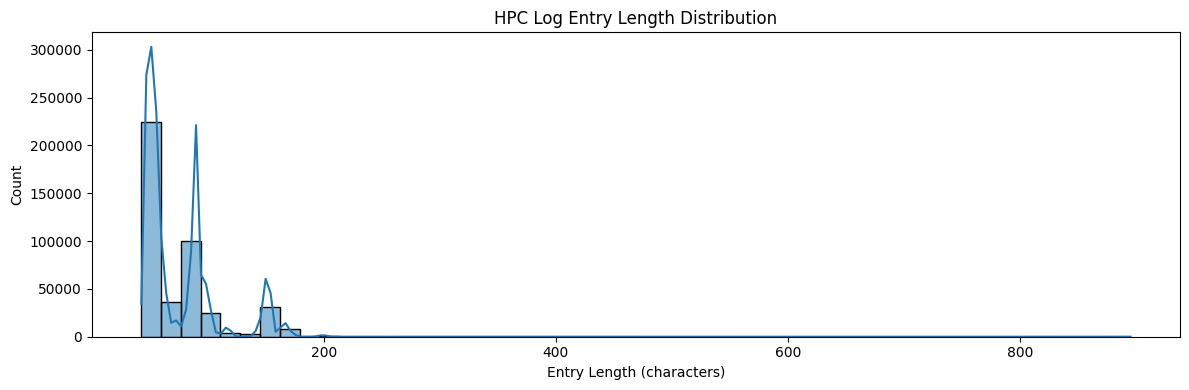


LINUX Log Entry Lengths:
  Total entries: 25567
  Min length: 28
  Max length: 1030
  Mean length: 90.72
  Std dev: 40.90


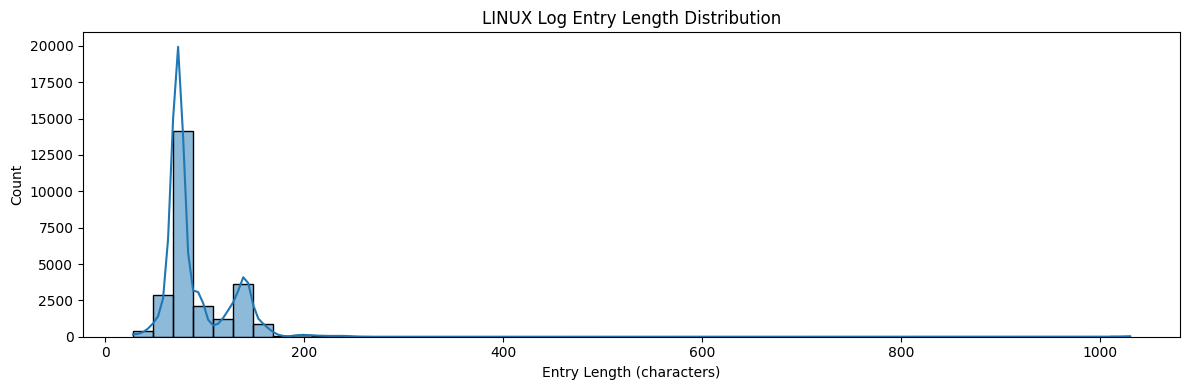


MAC Log Entry Lengths:
  Total entries: 116735
  Min length: 1
  Max length: 1314
  Mean length: 142.26
  Std dev: 93.25


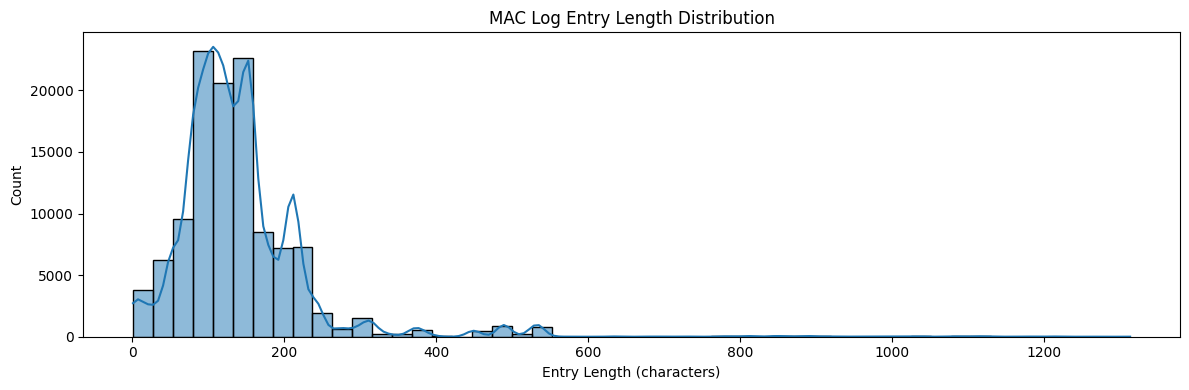

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Create a directory for saving EDA plots if it doesn't exist
plot_dir = Path("eda_plots")
plot_dir.mkdir(exist_ok=True)

def explore_entry_length(logs, name):
    """
    Analyze and visualize the length of log entries for a dataset.
    Saves the plot as an image in the 'eda_plots' directory.
    """
    lengths = [len(line) for line in logs]
    print(f"\n{name} Log Entry Lengths:")
    print(f"  Total entries: {len(logs)}")
    print(f"  Min length: {min(lengths) if lengths else 0}")
    print(f"  Max length: {max(lengths) if lengths else 0}")
    print(f"  Mean length: {sum(lengths)/len(lengths) if lengths else 0:.2f}")
    print(f"  Std dev: {pd.Series(lengths).std() if lengths else 0:.2f}")

    # Visualize
    plt.figure(figsize=(12, 4))
    sns.histplot(lengths, bins=50, kde=True)
    plt.title(f"{name} Log Entry Length Distribution")
    plt.xlabel("Entry Length (characters)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_entry_length.png")
    plt.show()

# Example for HDFS
hdfs_logs = read_log_file(hdfs_path)
apache_logs = read_log_file(apache_path)
healthapp_logs = read_log_file(health_path)
bgl_logs = read_log_file(bgl_path)
hpc_logs = read_log_file(hpc_path)
linux_logs = read_log_file(linux_path)
mac_logs = read_log_file(mac_path)
explore_entry_length(apache_logs,'APACHE')
explore_entry_length(hdfs_logs, "HDFS")
explore_entry_length(bgl_logs, "BGL")
explore_entry_length(healthapp_logs, "HEALTHAPP")
explore_entry_length(hpc_logs, "HPC")
explore_entry_length(linux_logs, "LINUX")
explore_entry_length(mac_logs, "MAC")
# Repeat for other datasets as needed

### Missing or Malformed Entries

Here, we check for empty or obviously malformed log entries.  
- Empty entries may result from logging errors, file corruption, or preprocessing issues.
- Identifying and quantifying these entries helps us decide whether to drop, impute, or further investigate them.
- Clean data is essential for reliable feature extraction and drift detection.

In [74]:
def check_missing_entries(logs, name):
    """
    Check for empty or obviously malformed entries.
    """
    empty_count = sum(1 for line in logs if not line)
    print(f"{name}: {empty_count} empty entries found.")

# Example for HDFS
check_missing_entries(hdfs_logs, "HDFS")
check_missing_entries(apache_logs,'APACHE')
check_missing_entries(bgl_logs, "BGL")
check_missing_entries(healthapp_logs, "HEALTHAPP")
check_missing_entries(hpc_logs, "HPC")
check_missing_entries(linux_logs, "LINUX")
check_missing_entries(mac_logs, "MAC")
# Repeat for other datasets

HDFS: 0 empty entries found.
APACHE: 0 empty entries found.
BGL: 0 empty entries found.
HEALTHAPP: 0 empty entries found.
HPC: 0 empty entries found.
LINUX: 0 empty entries found.
MAC: 0 empty entries found.


### Message Type Analysis

We analyze the frequency of different message types (e.g., INFO, ERROR, WARNING) in each dataset.  
- This step helps us understand the operational context and health of each system.
- High error or warning rates may indicate instability or drift.
- Visualizing message type distributions provides a quick overview of system behavior and logging practices.


HDFS Message Type Distribution:
  INFO: 1920 (96.00%)
  ERROR: 80 (4.00%)


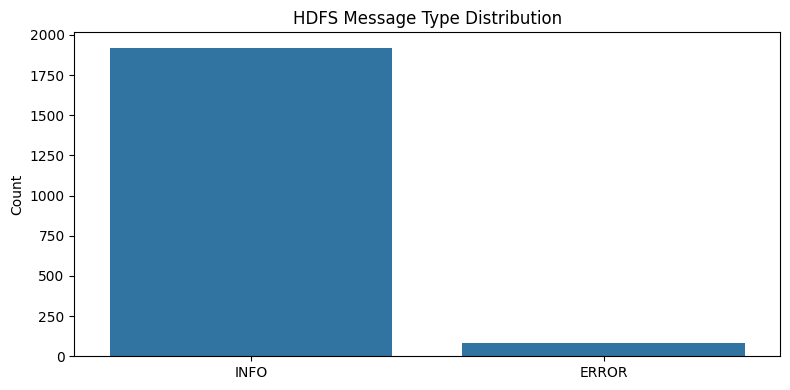


APACHE Message Type Distribution:
  INFO: 13755 (24.35%)
  ERROR: 38081 (67.42%)
  OTHER: 4478 (7.93%)


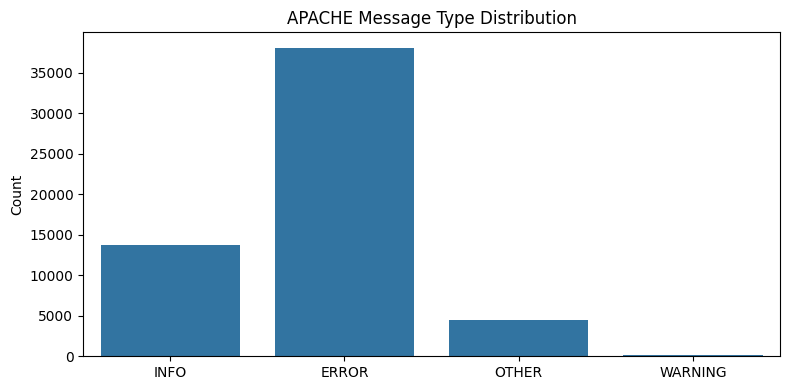


BGL Message Type Distribution:
  ERROR: 1394876 (29.38%)
  INFO: 2917660 (61.45%)
  CRITICAL: 384491 (8.10%)
  DEBUG: 15429 (0.32%)
  OTHER: 957 (0.02%)


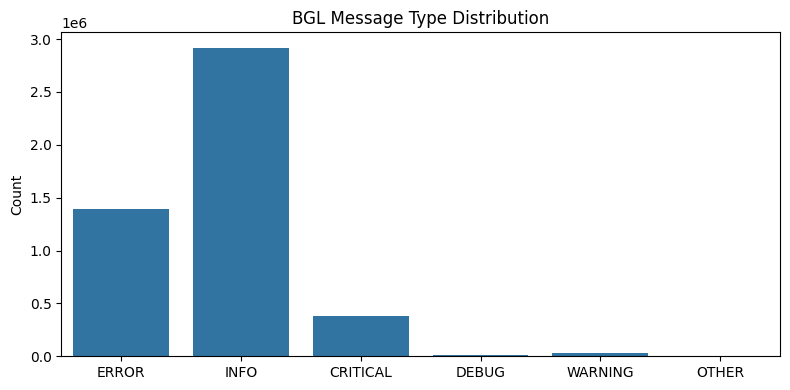


HEALTHAPP Message Type Distribution:
  OTHER: 251661 (99.32%)
  ERROR: 1704 (0.67%)
  INFO: 25 (0.01%)
  DEBUG: 5 (0.00%)


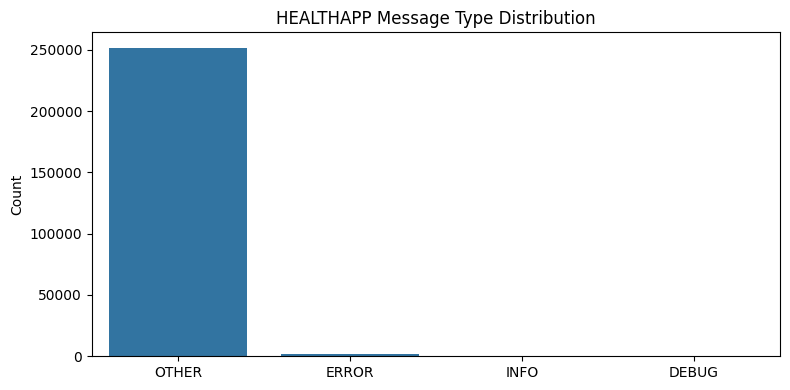


HPC Message Type Distribution:
  ERROR: 111016 (25.61%)
  OTHER: 267163 (61.63%)
  CRITICAL: 4629 (1.07%)


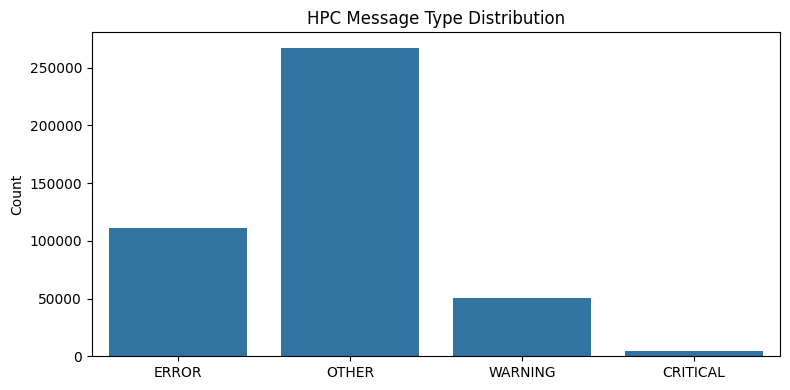


LINUX Message Type Distribution:
  OTHER: 21230 (83.04%)
  ERROR: 4181 (16.35%)
  INFO: 38 (0.15%)
  DEBUG: 99 (0.39%)


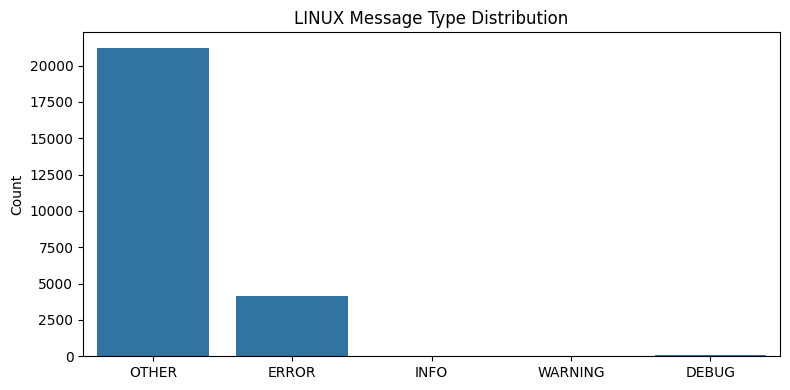


MAC Message Type Distribution:
  OTHER: 95450 (81.77%)
  ERROR: 19089 (16.35%)
  INFO: 1705 (1.46%)
  DEBUG: 168 (0.14%)


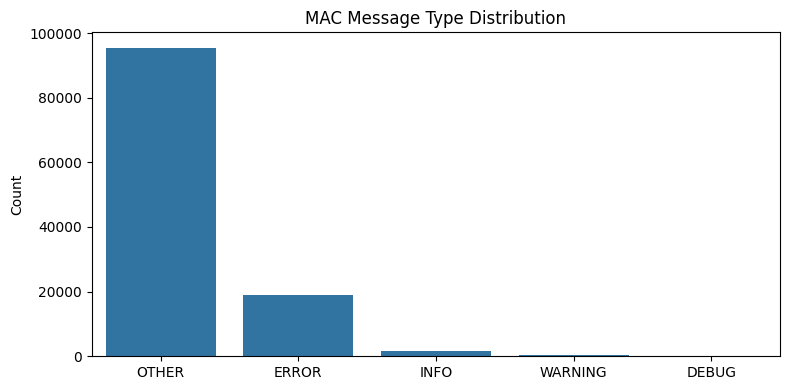

In [76]:
import re
from collections import Counter

def analyze_message_types(logs, name):

       """
       Analyze the frequency of different message types (INFO, ERROR, etc.).
       Saves the plot as an image in the 'eda_plots' directory.
       """
       patterns = {
           'ERROR': r'error|ERROR|Error|FAIL|fail|Fail|EXCEPTION|exception|Exception',
           'WARNING': r'warn|WARN|Warn|WARNING|warning|Warning',
           'INFO': r'info|INFO|Info|NOTICE|notice|Notice',
           'DEBUG': r'debug|DEBUG|Debug|TRACE|trace|Trace',
           'CRITICAL': r'critical|CRITICAL|Critical|FATAL|fatal|Fatal|EMERGENCY|emergency|Emergency'
       }
       type_counts = Counter()
       for log in logs:
           for type_name, pattern in patterns.items():
               if re.search(pattern, log):
                   type_counts[type_name] += 1
                   break
           else:
               type_counts['OTHER'] += 1
       print(f"\n{name} Message Type Distribution:")
       for t, c in type_counts.items():
           print(f"  {t}: {c} ({c/len(logs)*100:.2f}%)")
       # Visualize
       plt.figure(figsize=(8, 4))
       sns.barplot(x=list(type_counts.keys()), y=list(type_counts.values()))
       plt.title(f"{name} Message Type Distribution")
       plt.ylabel("Count")
       plt.tight_layout()
       plt.savefig(plot_dir / f"{name.lower()}_message_types.png")
       plt.show()
# Example for HDFS
analyze_message_types(hdfs_logs, "HDFS")
analyze_message_types(apache_logs,'APACHE')
analyze_message_types(bgl_logs, "BGL")
analyze_message_types(healthapp_logs, "HEALTHAPP")
analyze_message_types(hpc_logs, "HPC")
analyze_message_types(linux_logs, "LINUX")
analyze_message_types(mac_logs, "MAC")
# Repeat for other datasets

### Timestamp & Temporal Coverage

In this step, we extract and analyze timestamps from log entries.  
- We assess the temporal coverage of each dataset (earliest and latest log entries).
- Visualizing the number of log entries over time helps identify periods of high or low activity, gaps, or bursts.
- Understanding temporal patterns is crucial for drift detection and time-based feature engineering.


Temporal Statistics for HDFS:
Timestamps found: 2000
Time range: 2008-11-09 20:36:15 to 2008-11-11 10:20:17
Average time between logs: 67.95 seconds
Min time between logs: 0.00 seconds
Max time between logs: 3481.00 seconds


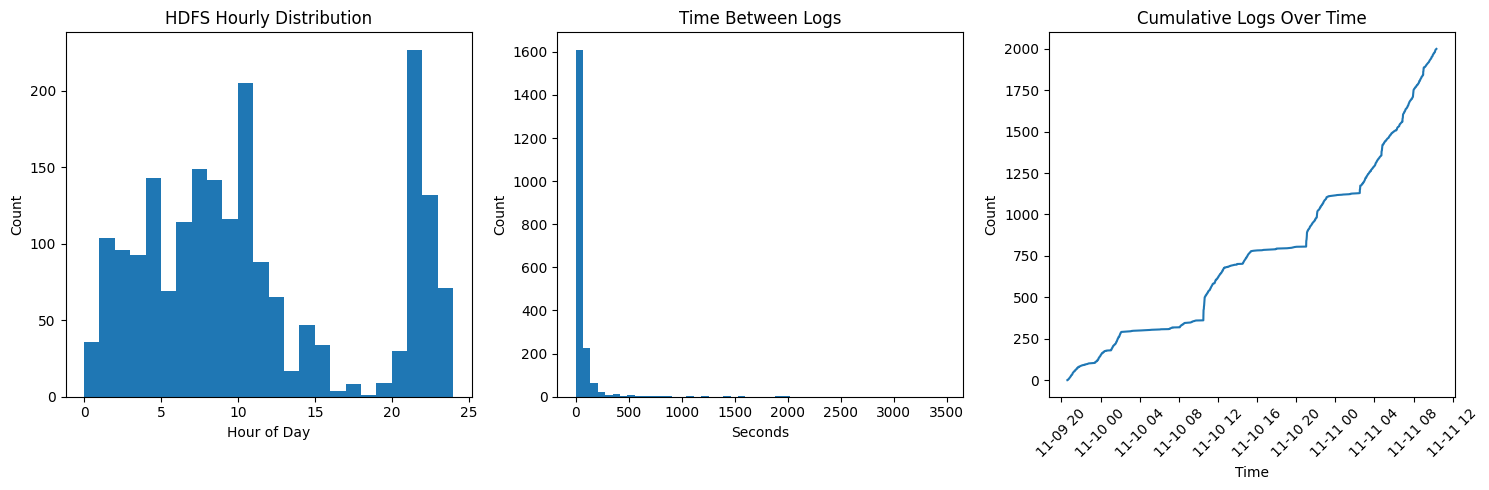


Temporal Patterns:
Most common hours: [(21, 227), (10, 205), (7, 149)]
Most common days: [(10, 965), (11, 885), (9, 150)]
Most common months: [(11, 2000)]
Most common weekdays: [(0, 965), (1, 885), (6, 150)]

Temporal Statistics for APACHE:
Timestamps found: 52004
Time range: 1900-01-01 04:02:13 to 1900-12-25 04:02:20
Average time between logs: -167.96 seconds
Min time between logs: -30931207.00 seconds
Max time between logs: 604794.00 seconds


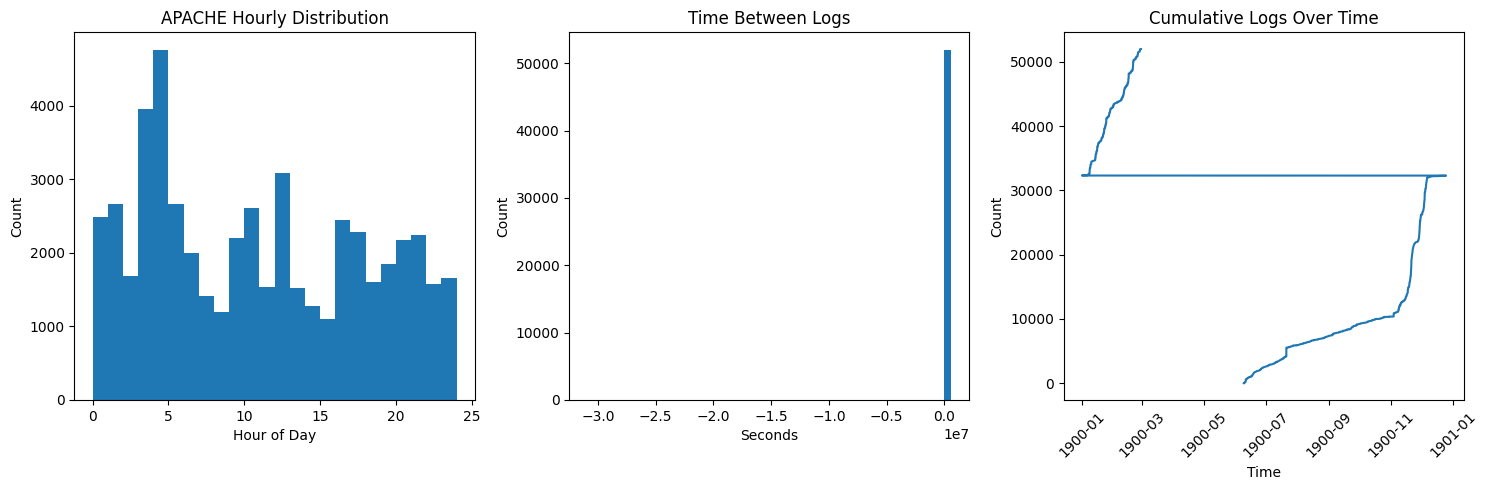


Temporal Patterns:
Most common hours: [(4, 4761), (3, 3958), (12, 3087)]
Most common days: [(21, 4247), (20, 4121), (22, 2431)]
Most common months: [(11, 15862), (1, 10905), (2, 8790)]
Most common weekdays: [(1, 10173), (3, 8324), (2, 8285)]

Temporal Statistics for BGL:
Timestamps found: 11925
Time range: 1900-06-17 07:25:00 to 2055-09-19 00:00:04
Average time between logs: 1415.56 seconds
Min time between logs: -4882857001.00 seconds
Max time between logs: 4884589217.00 seconds


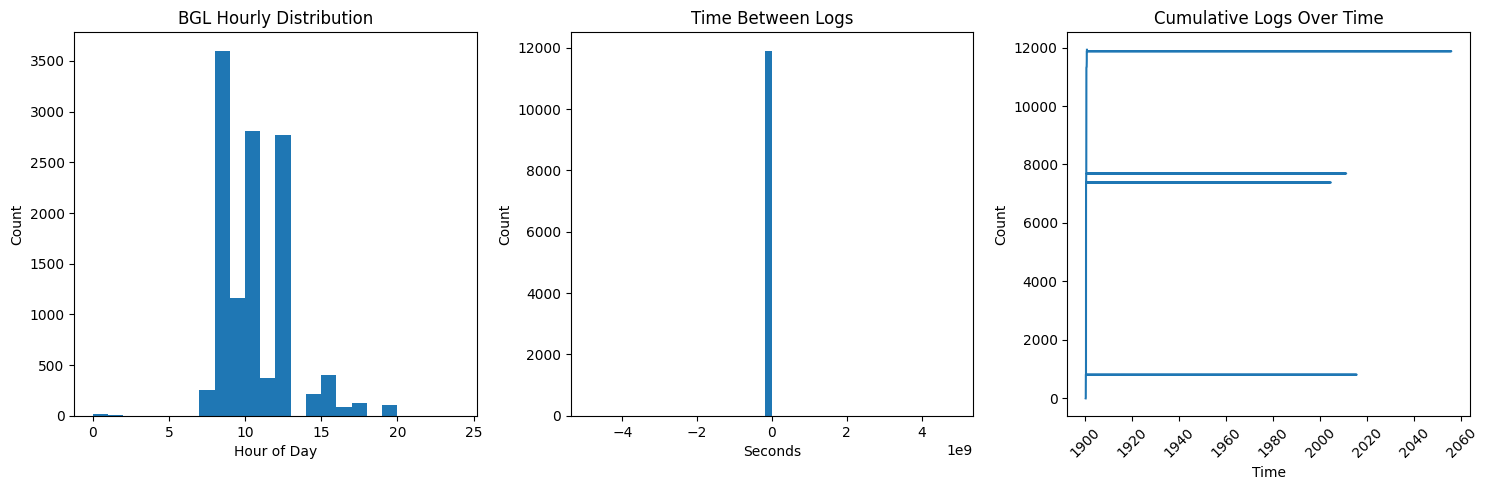


Temporal Patterns:
Most common hours: [(8, 3602), (10, 2807), (12, 2772)]
Most common days: [(20, 3384), (4, 3232), (9, 2691)]
Most common months: [(8, 6587), (9, 3899), (7, 809)]
Most common weekdays: [(3, 6390), (5, 3263), (6, 1060)]

Temporal Statistics for HEALTHAPP:
Timestamps found: 14
Time range: 2018-01-02 18:52:59 to 2018-01-02 18:52:59
Average time between logs: 0.00 seconds
Min time between logs: 0.00 seconds
Max time between logs: 0.00 seconds


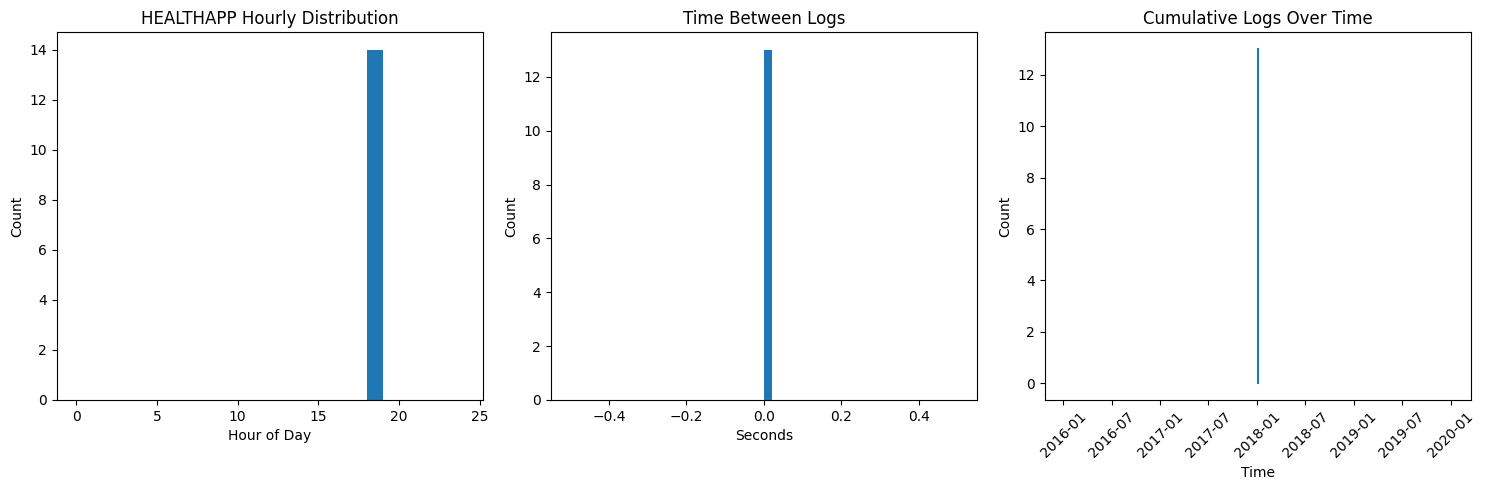


Temporal Patterns:
Most common hours: [(18, 14)]
Most common days: [(2, 14)]
Most common months: [(1, 14)]
Most common weekdays: [(1, 14)]
No timestamps found in the logs for HPC

First few log entries for format reference:
- 460903 resourcemgmtdaeomon node-25 server subsys 1145552216 1 failed to configure resourcemgmt subsystem err = 10
- 460919 resourcemgmtdaeomon node-25 server subsys 1145552221 1 failed to configure resourcemgmt subsystem err = 10
- 460932 resourcemgmtdaeomon node-25 server subsys 1145552226 1 failed to configure resourcemgmt subsystem err = 10

Temporal Statistics for LINUX:
Timestamps found: 25567
Time range: 1900-01-01 04:02:05 to 1900-12-31 04:07:34
Average time between logs: -341.51 seconds
Min time between logs: -31449929.00 seconds
Max time between logs: 218841.00 seconds


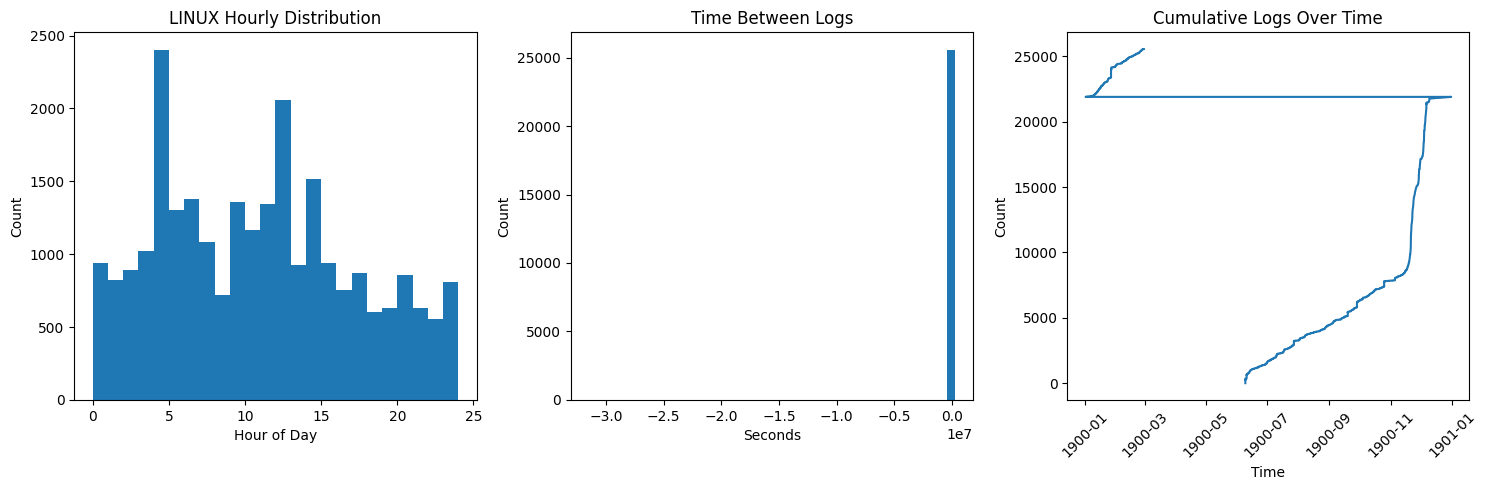


Temporal Patterns:
Most common hours: [(4, 2402), (12, 2061), (14, 1514)]
Most common days: [(21, 1961), (4, 1541), (22, 1491)]
Most common months: [(11, 9315), (12, 4750), (1, 2439)]
Most common weekdays: [(2, 4927), (3, 4687), (1, 4090)]

Temporal Statistics for MAC:
Timestamps found: 107201
Time range: 1900-07-01 08:58:36 to 2017-07-08 15:51:26
Average time between logs: 5.64 seconds
Min time between logs: -3692271599.00 seconds
Max time between logs: 3692271600.00 seconds


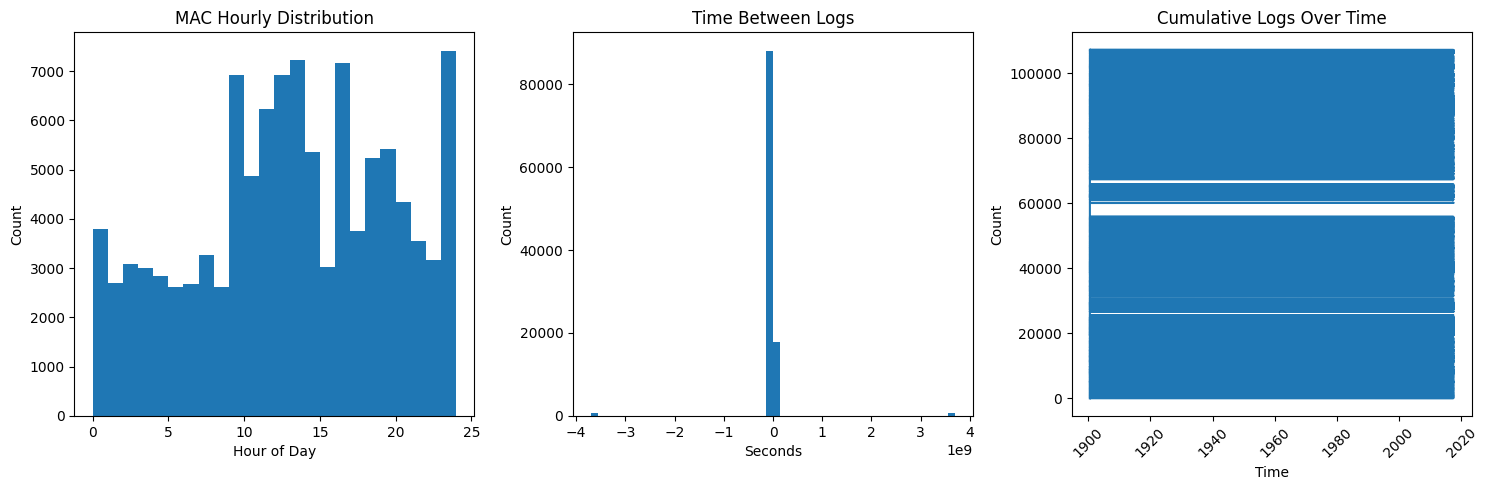


Temporal Patterns:
Most common hours: [(23, 7420), (13, 7228), (16, 7174)]
Most common days: [(4, 21800), (3, 19108), (7, 15962)]
Most common months: [(7, 107162), (2, 39)]
Most common weekdays: [(2, 21748), (1, 19151), (6, 16609)]


In [77]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def analyze_temporal_patterns(logs, name, plot_dir=Path("eda_plots")):
    """
    Extract and analyze timestamps from log entries using multiple common patterns.
    Saves visualizations to the specified plot directory.
    """
    # Extended timestamp patterns
    timestamp_patterns = [
        # HDFS format (e.g., "081109 203518" for Nov 9, 2008 20:35:18)
        (r'(\d{6}\s+\d{6})', '%y%m%d %H%M%S'),
        # ISO format
        (r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y-%m-%d %H:%M:%S'),
        # Syslog format
        (r'(\w{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2})', '%b %d %H:%M:%S'),
        # Common log format
        (r'(\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}:\d{2})', '%m/%d/%Y %H:%M:%S'),
        # Apache format
        (r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2})', '%d/%b/%Y:%H:%M:%S')
    ]
    
    timestamps = []
    for log in logs:
        for pattern, time_format in timestamp_patterns:
            match = re.search(pattern, log)
            if match:
                try:
                    timestamp_str = match.group(1)
                    # For HDFS format, add century (assuming 20xx)
                    if len(timestamp_str) == 13 and ' ' in timestamp_str:  # HDFS format
                        timestamp = datetime.strptime(f"20{timestamp_str}", '%Y%m%d %H%M%S')
                    else:
                        timestamp = datetime.strptime(timestamp_str, time_format)
                    timestamps.append(timestamp)
                    break
                except ValueError:
                    continue
    
    if timestamps:
        print(f"\nTemporal Statistics for {name}:")
        print(f"Timestamps found: {len(timestamps)}")
        print(f"Time range: {min(timestamps)} to {max(timestamps)}")
        
        # Calculate time differences
        time_diffs = [(timestamps[i+1] - timestamps[i]).total_seconds() 
                     for i in range(len(timestamps)-1)]
        
        if time_diffs:
            print(f"Average time between logs: {np.mean(time_diffs):.2f} seconds")
            print(f"Min time between logs: {min(time_diffs):.2f} seconds")
            print(f"Max time between logs: {max(time_diffs):.2f} seconds")
        
        # Visualizations
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        hours = [t.hour for t in timestamps]
        plt.hist(hours, bins=24, range=(0,24))
        plt.title(f"{name} Hourly Distribution")
        plt.xlabel("Hour of Day")
        plt.ylabel("Count")
        
        if time_diffs:
            plt.subplot(132)
            plt.hist(time_diffs, bins=50)
            plt.title("Time Between Logs")
            plt.xlabel("Seconds")
            plt.ylabel("Count")
        
        plt.subplot(133)
        plt.plot(timestamps, range(len(timestamps)))
        plt.title("Cumulative Logs Over Time")
        plt.xlabel("Time")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(plot_dir / f'{name.lower()}_temporal_patterns.png')
        plt.show()
        plt.close()
        
        # Additional temporal patterns
        print("\nTemporal Patterns:")
        days = [t.day for t in timestamps]
        months = [t.month for t in timestamps]
        weekdays = [t.weekday() for t in timestamps]
        
        print(f"Most common hours: {Counter(hours).most_common(3)}")
        print(f"Most common days: {Counter(days).most_common(3)}")
        print(f"Most common months: {Counter(months).most_common(3)}")
        print(f"Most common weekdays: {Counter(weekdays).most_common(3)}")  # 0=Monday, 6=Sunday
        
    else:
        print(f"No timestamps found in the logs for {name}")
        # Print first few log entries to help debug timestamp extraction
        print("\nFirst few log entries for format reference:")
        for log in logs[:3]:
            print(f"- {log}")

# Example usage:
analyze_temporal_patterns(hdfs_logs, "HDFS")
analyze_temporal_patterns(apache_logs,'APACHE')
analyze_temporal_patterns(bgl_logs, "BGL")
analyze_temporal_patterns(healthapp_logs, "HEALTHAPP")
analyze_temporal_patterns(hpc_logs, "HPC")
analyze_temporal_patterns(linux_logs, "LINUX")
analyze_temporal_patterns(mac_logs, "MAC")

In [79]:
import re
from collections import Counter

def extract_timestamps(logs, time_format, name):
    timestamps = []
    for log in logs:
        try:
            # Adjusted regex for Apache logs
            match = re.search(r'\[(\d{2}/[A-Za-z]{3}/\d{4}:\d{2}:\d{2}:\d{2})', log)
            if match:
                timestamps.append(datetime.strptime(match.group(1), time_format))
        except Exception:
            continue
    if timestamps:
        print(f"\n{name} Temporal Coverage:")
        print(f"  Earliest: {min(timestamps)}")
        print(f"  Latest: {max(timestamps)}")
        plt.figure(figsize=(12, 4))
        sns.histplot([t.date() for t in timestamps], bins=30)
        plt.title(f"{name} Log Entries Over Time")
        plt.xlabel("Date")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(plot_dir / f"{name.lower()}_temporal_coverage.png")
        plt.show()
    else:
        print(f"{name}: No timestamps found or format mismatch.")

# Now call with the correct format
extract_timestamps(apache_logs, "%d/%b/%Y:%H:%M:%S", "Apache")
extract_timestamps(bgl_logs,"%d/%b/%Y:%H:%M:%S", "BGL")
extract_timestamps(healthapp_logs,"%d/%b/%Y:%H:%M:%S", "HEALTHAPP")
extract_timestamps(hpc_logs,"%d/%b/%Y:%H:%M:%S", "HPC")
extract_timestamps(linux_logs,"%d/%b/%Y:%H:%M:%S", "LINUX")
extract_timestamps(mac_logs,"%d/%b/%Y:%H:%M:%S", "MAC")
extract_timestamps(hdfs_logs,"%d/%b/%Y:%H:%M:%S", "HDFS")


Apache: No timestamps found or format mismatch.
BGL: No timestamps found or format mismatch.
HEALTHAPP: No timestamps found or format mismatch.
HPC: No timestamps found or format mismatch.
LINUX: No timestamps found or format mismatch.
MAC: No timestamps found or format mismatch.
HDFS: No timestamps found or format mismatch.


### Component Diversity Analysis

We extract and analyze the diversity of system components referenced in the logs using an extensive set of regular expressions.  
- This approach captures components in various formats, such as those enclosed in brackets, following log levels, or specific to certain systems (e.g., HDFS block IDs, daemon names).
- A comprehensive extraction helps us understand which parts of the system are most active or error-prone, even in verbose logs like those from Mac systems.
- Visualizing component frequencies provides insight into system architecture, operational hotspots, and potential sources of drift.


Mac Top Components (extensive extraction):
  0: 41639
  258: 6945
  null: 4455
  14463: 4056
  43: 3669
  10018: 3497
  1: 2967
  32778: 2462
  184: 2294
  82: 2233


/var/folders/dr/8_j4tm8j7_v5ymfll6_zyz4w0000gn/T/ipykernel_91988/948210714.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


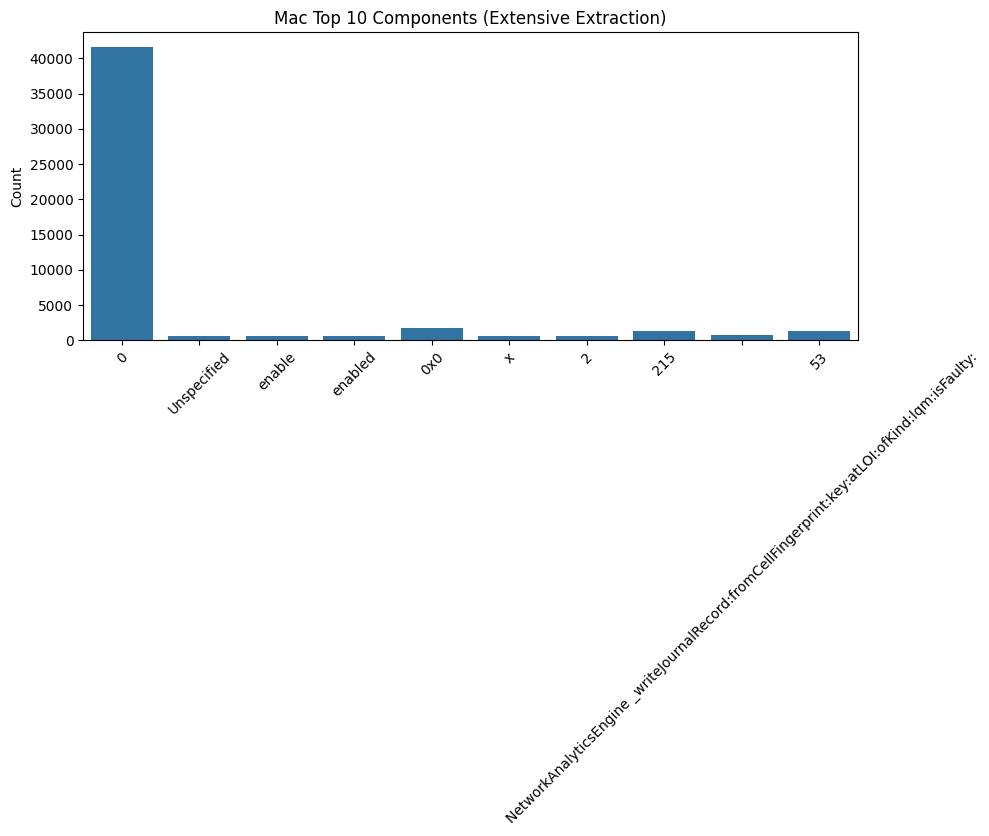


APACHE Top Components (extensive extraction):
  error: 38081
  notice: 13755
  client 218.144.240.75: 1002
  218.144.240.75: 1002
  client 210.245.233.251: 624
  210.245.233.251: 624
  client 211.99.203.228: 440
  211.99.203.228: 440
  client 80.55.121.106: 322
  80.55.121.106: 322


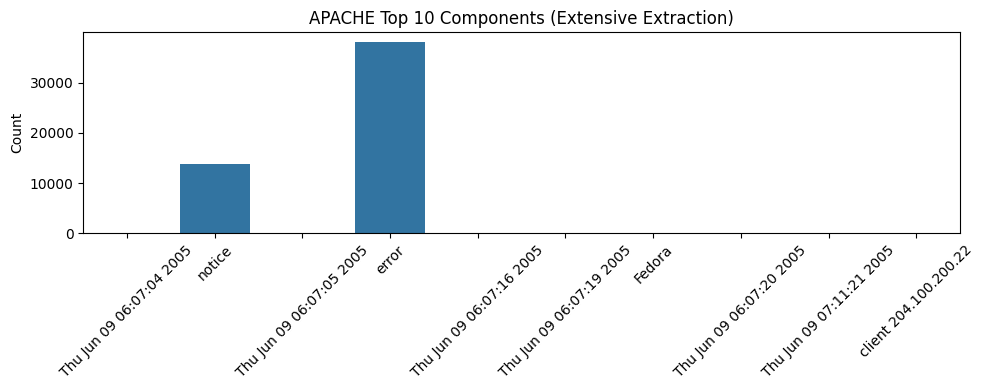


BGL Top Components (extensive extraction):
  ciod: 122181
  s: 117090
  idoproxydb hit ASSERT condition: 84253
  program interrupt: 20691
  Node card VPD check: 20583
  Node card status: 17513
  Ido chip status changed: 11904
  instruction address: 3664
  exception syndrome register: 3662
  machine check: 3662


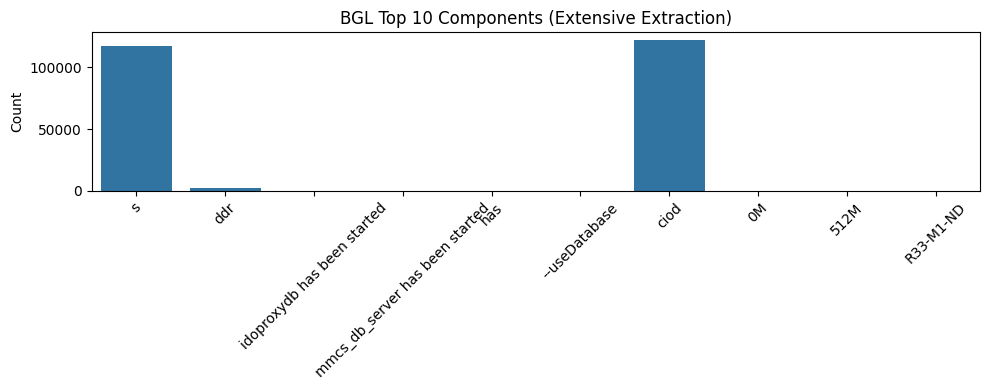


HEALTHAPP Top Components (extensive extraction):
  20171230-22: 9454
  20171224-20: 8939
  20171224-18: 7058
  201812-8: 5955
  201812-22: 5899
  20171225-19: 5533
  20171229-12: 5519
  20171224-22: 5358
  20171225-23: 5292
  20171226-22: 5277


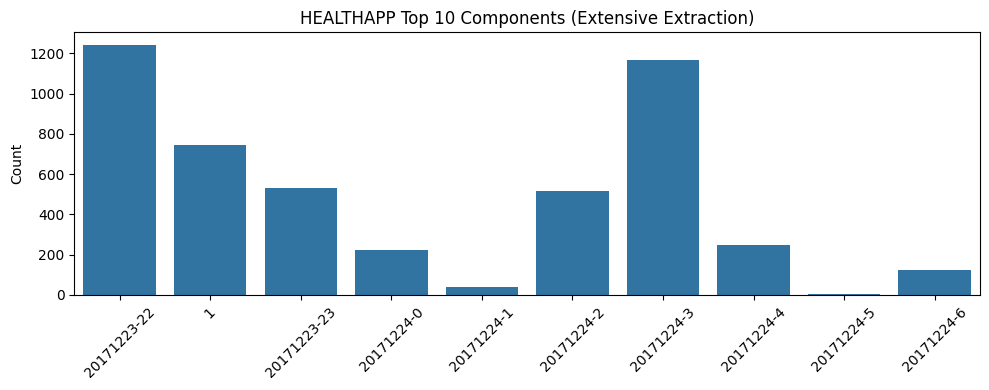


HPC Top Components (extensive extraction):
  for: 5126
  41C: 420
  status: 362
  42C: 350
  43C: 171
  0-7: 93
  1074289164: 84
  1074288832: 82
  0-31: 68
  1074289165: 64


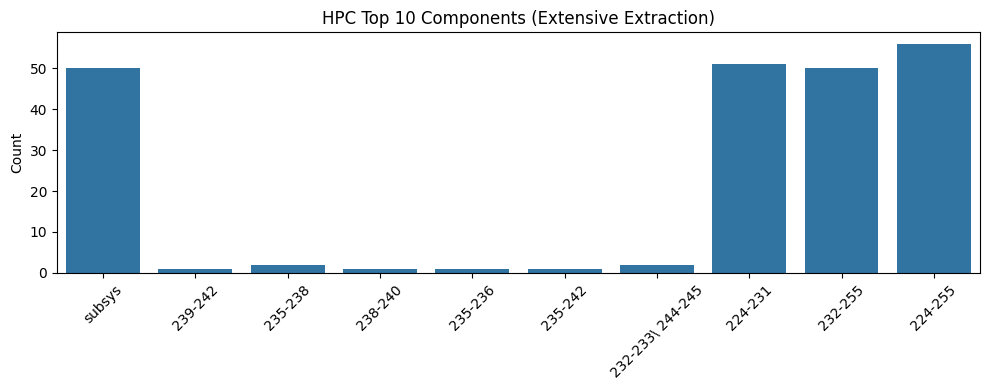


LINUX Top Components (extensive extraction):
  httpd: 8903
  pam_unix: 5980
  python: 1153
  1: 239
  sendmail: 230
  dslb-084-057-172-016.pools.arcor-ip.net: 189
  <02114408>: 102
  <0212ebf3>: 90
  <02114537>: 73
  ext3: 71


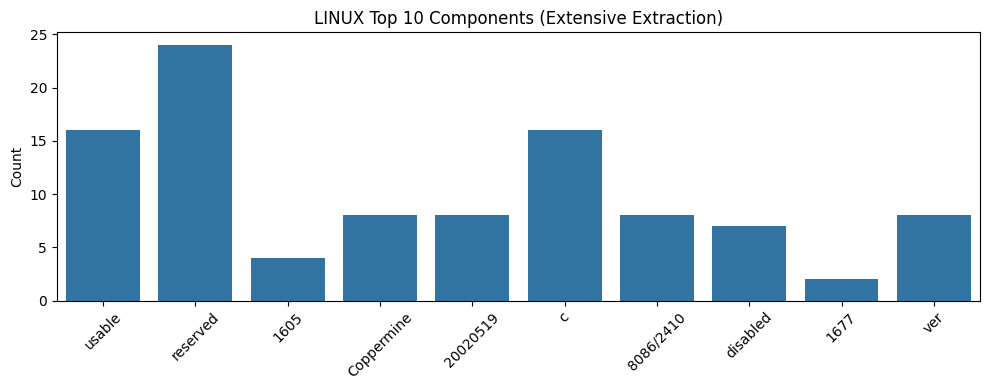


HDFS Top Components (extensive extraction):
  DataNode: 1058
  PacketResponder: 914
  dfs.FSNamesystem: 659
  FSNamesystem: 659
  dfs.DataNode$PacketResponder: 603
  dfs.DataNode$DataXceiver: 454
  dfs.FSDataset: 263
  dfs.DataBlockScanner: 20
  blk_-8775602795571523802: 4
  blk_1781953582842324563: 2


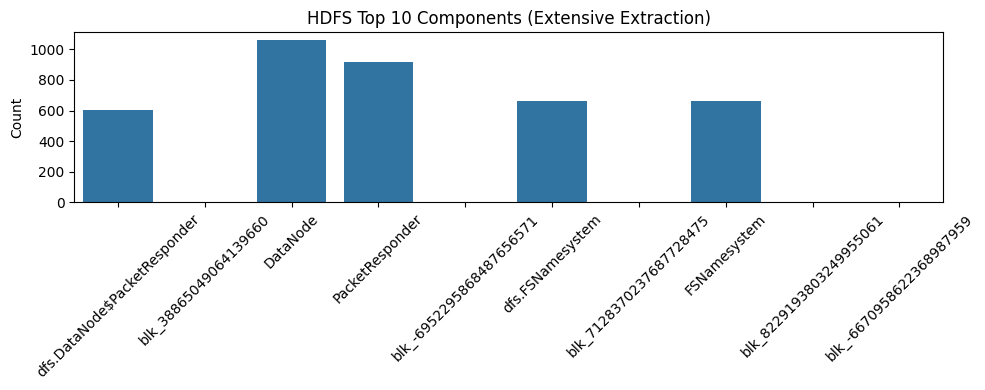

In [81]:
import re
from collections import Counter


def analyze_components_extensive(logs, name):
    """
    Extract and analyze component names from log entries using a comprehensive set of regex patterns.
    Saves the plot as an image in the 'eda_plots' directory.
    """
    patterns = [
        r'\[(.*?)\]',                          # [Component]
        r'^([A-Za-z0-9_-]+):',                 # Component:
        r'(?:INFO|ERROR|WARN)\s+([^:]+):',     # INFO Component:
        r'\(([\w.-]+)\)',                      # (Component)
        r'(?:daemon|server|client)\s+([\w.-]+)',  # daemon/server/client names
        r'blk_[-\d]+',                         # HDFS block IDs
        r'BP-[\d\-]+',                         # HDFS block pool IDs
        r'DFSClient_[\w.-]+',                  # DFS Client IDs
        r'NameNode',                           # NameNode references
        r'DataNode',                           # DataNode references
        r'FSNamesystem',                       # FSNamesystem references
        r'PacketResponder',                    # PacketResponder references
    ]
    components = []
    for log in logs:
        for pattern in patterns:
            found = re.findall(pattern, log)
            if found:
                if isinstance(found, list):
                    components.extend([comp for comp in found if comp])
                else:
                    components.append(found)
    if components:
        comp_counts = Counter(components)
        print(f"\n{name} Top Components (extensive extraction):")
        for comp, count in comp_counts.most_common(10):
            print(f"  {comp}: {count}")
        plt.figure(figsize=(10, 4))
        sns.barplot(x=list(comp_counts.keys())[:10], y=list(comp_counts.values())[:10])
        plt.title(f"{name} Top 10 Components (Extensive Extraction)")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(plot_dir / f"{name.lower()}_components.png")
        plt.show()
    else:
        print(f"{name}: No components found with extensive patterns.")


#mac_logs = read_log_file(mac_path)
analyze_components_extensive(mac_logs, "Mac")
analyze_components_extensive(apache_logs,'APACHE')
analyze_components_extensive(bgl_logs, "BGL")
analyze_components_extensive(healthapp_logs, "HEALTHAPP")
analyze_components_extensive(hpc_logs, "HPC")
analyze_components_extensive(linux_logs, "LINUX")
analyze_components_extensive(hdfs_logs, "HDFS")


### Word Count Distribution

We analyze the distribution of the number of words in each log entry.  
This helps us understand the verbosity and structure of log messages, and may reveal outliers or unusual entries.


HDFS Word Count Stats:
  Min: 9
  Max: 110
  Mean: 12.44
  Std: 3.73


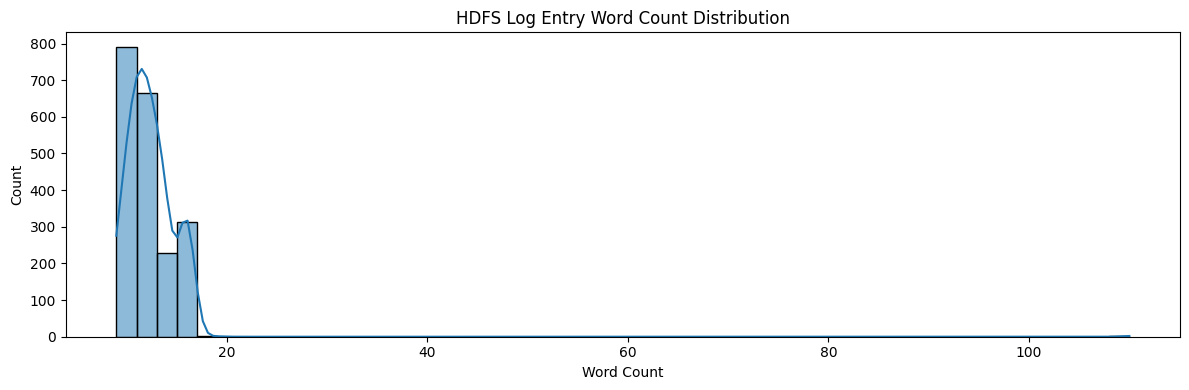


APACHE Word Count Stats:
  Min: 7
  Max: 23
  Mean: 12.39
  Std: 2.34


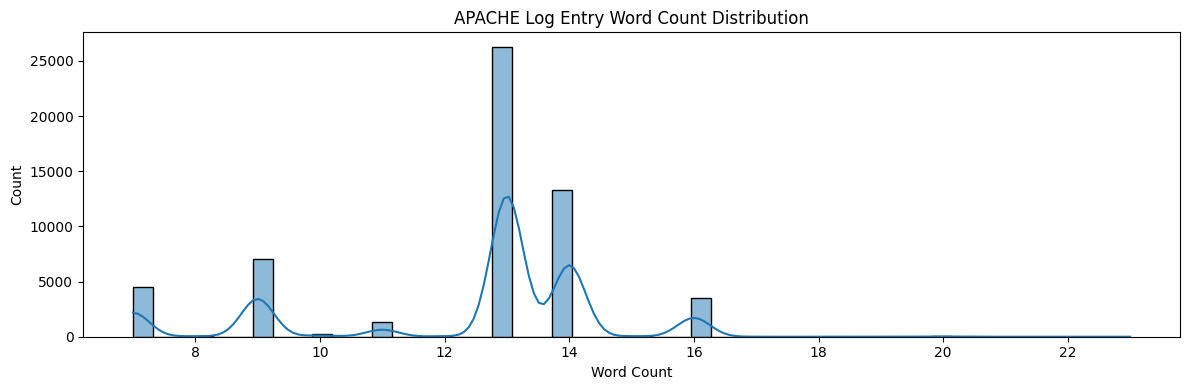


BGL Word Count Stats:
  Min: 9
  Max: 102
  Mean: 15.17
  Std: 7.48


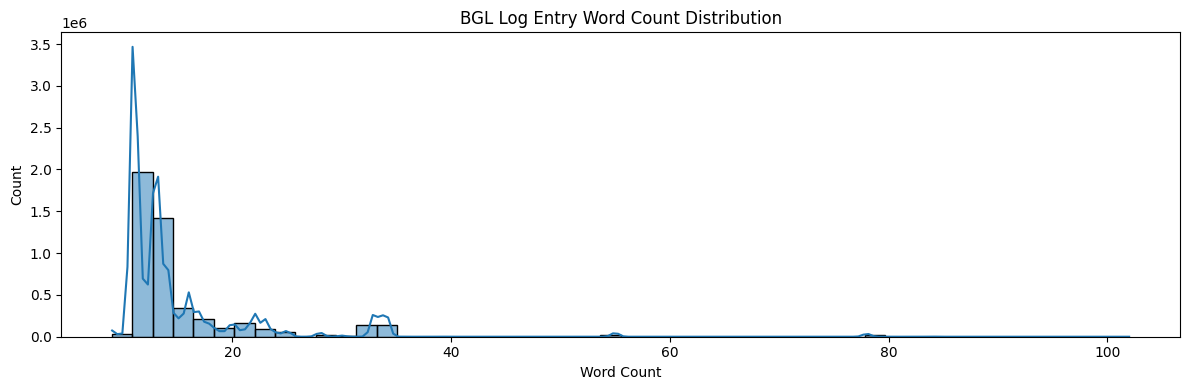


HEALTHAPP Word Count Stats:
  Min: 1
  Max: 21
  Mean: 3.28
  Std: 1.96


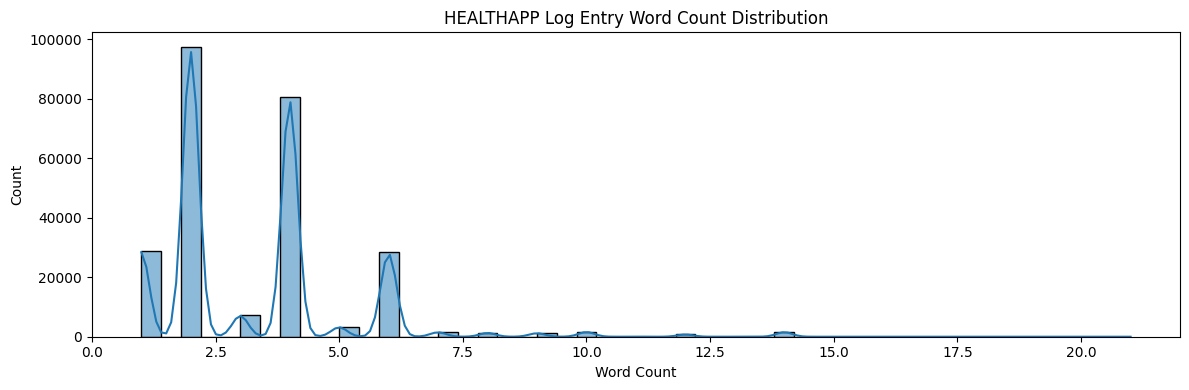


HPC Word Count Stats:
  Min: 6
  Max: 104
  Mean: 9.73
  Std: 4.09


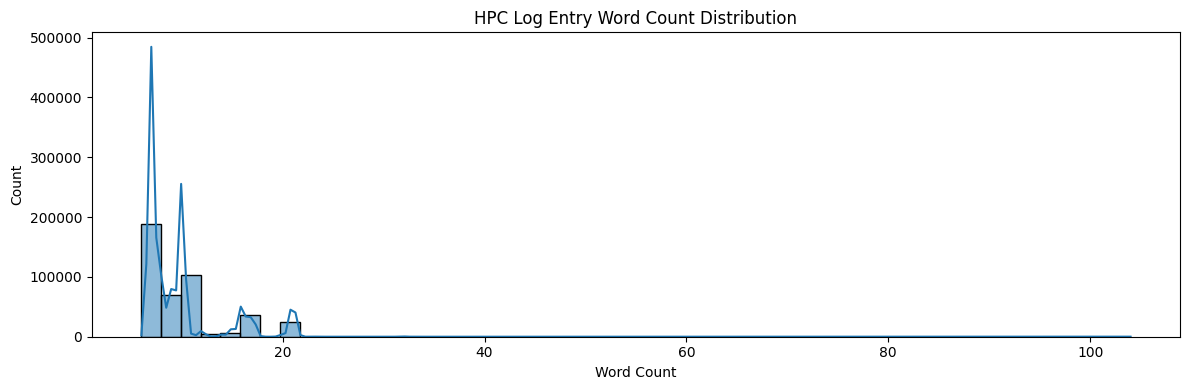


LINUX Word Count Stats:
  Min: 5
  Max: 24
  Mean: 12.05
  Std: 2.37


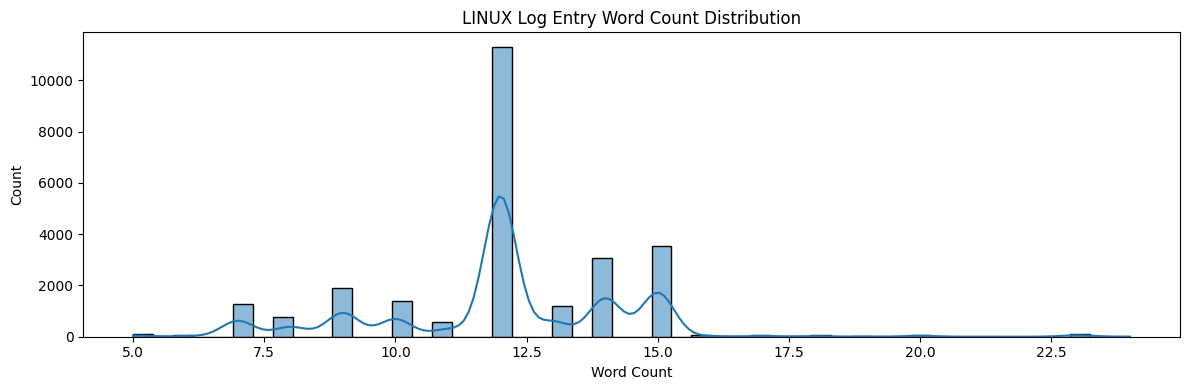


MAC Word Count Stats:
  Min: 1
  Max: 104
  Mean: 13.04
  Std: 6.50


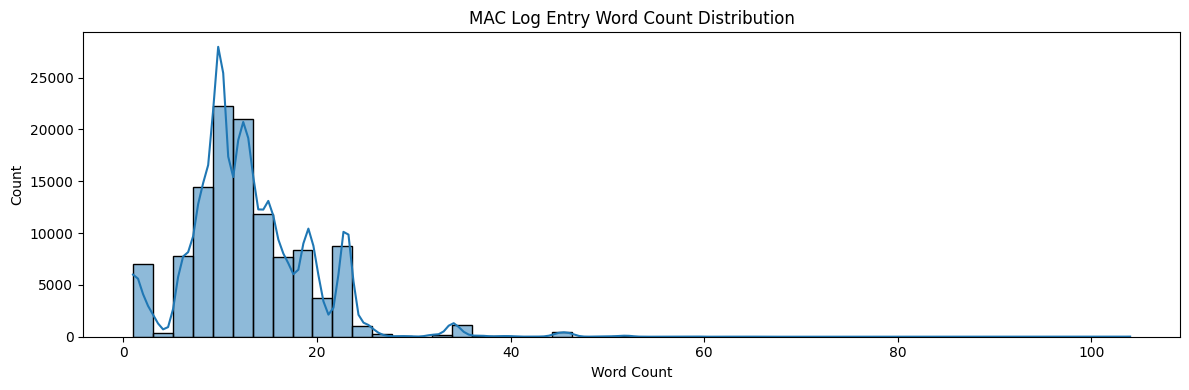

In [82]:
def explore_word_count(logs, name):
    word_counts = [len(line.split()) for line in logs]
    print(f"\n{name} Word Count Stats:")
    print(f"  Min: {min(word_counts) if word_counts else 0}")
    print(f"  Max: {max(word_counts) if word_counts else 0}")
    print(f"  Mean: {np.mean(word_counts) if word_counts else 0:.2f}")
    print(f"  Std: {np.std(word_counts) if word_counts else 0:.2f}")
    plt.figure(figsize=(12, 4))
    sns.histplot(word_counts, bins=50, kde=True)
    plt.title(f"{name} Log Entry Word Count Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_word_count.png")
    plt.show()

# Example usage:
explore_word_count(hdfs_logs, "HDFS")
explore_word_count(apache_logs,'APACHE')
explore_word_count(bgl_logs, "BGL")
explore_word_count(healthapp_logs, "HEALTHAPP")
explore_word_count(hpc_logs, "HPC")
explore_word_count(linux_logs, "LINUX")
explore_word_count(mac_logs, "MAC")

### Special Character Analysis

We examine the frequency of special (non-alphanumeric) characters in log entries.  
This can indicate the presence of stack traces, encoded data, or unusual formatting.


HDFS Special Character Stats:
  Min: 3
  Max: 158
  Mean: 11.46
  Std: 6.43


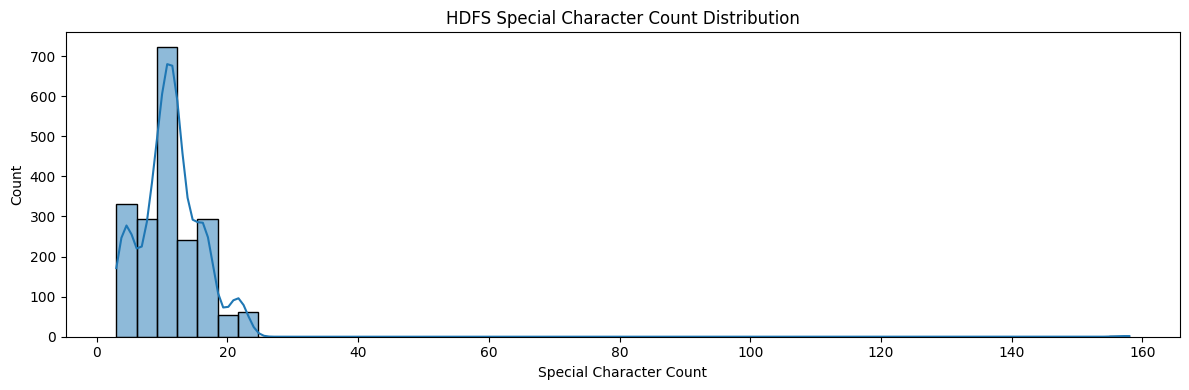


APACHE Special Character Stats:
  Min: 0
  Max: 43
  Mean: 12.69
  Std: 5.20


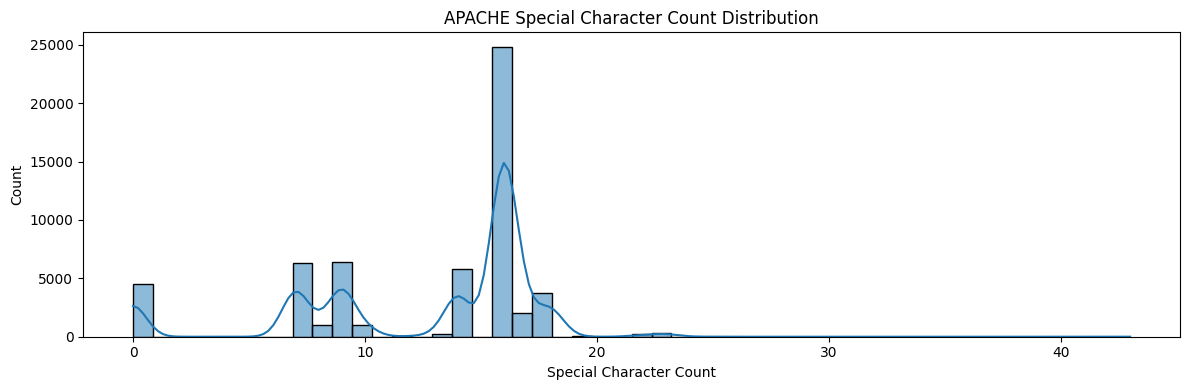


BGL Special Character Stats:
  Min: 8
  Max: 90
  Mean: 21.43
  Std: 4.64


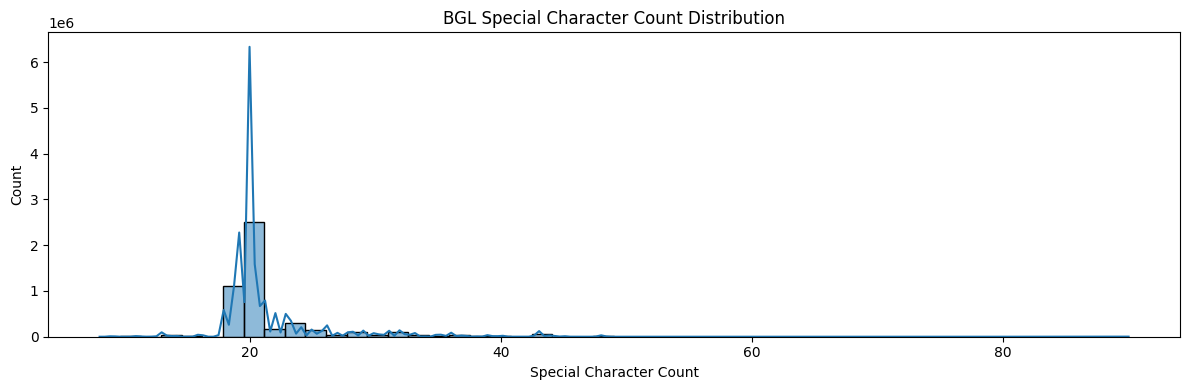


HEALTHAPP Special Character Stats:
  Min: 8
  Max: 119
  Mean: 11.69
  Std: 4.35


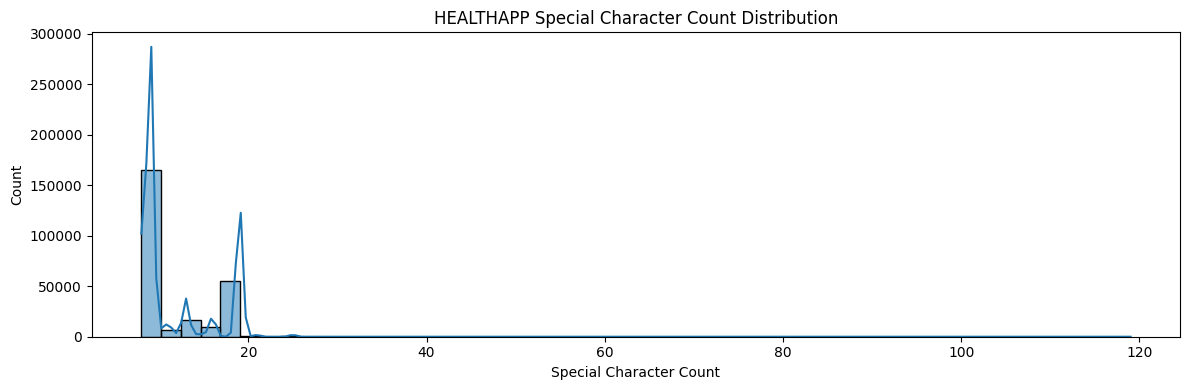


HPC Special Character Stats:
  Min: 0
  Max: 97
  Mean: 2.45
  Std: 3.07


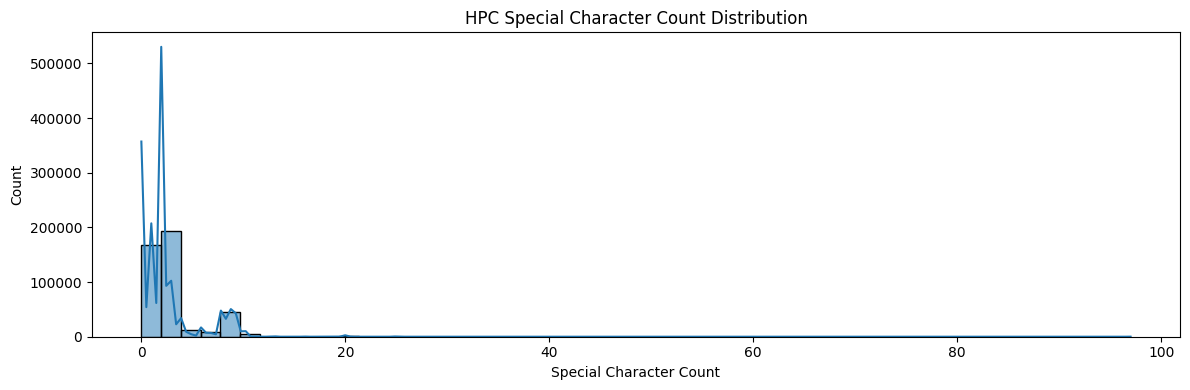


LINUX Special Character Stats:
  Min: 2
  Max: 260
  Mean: 10.72
  Std: 8.86


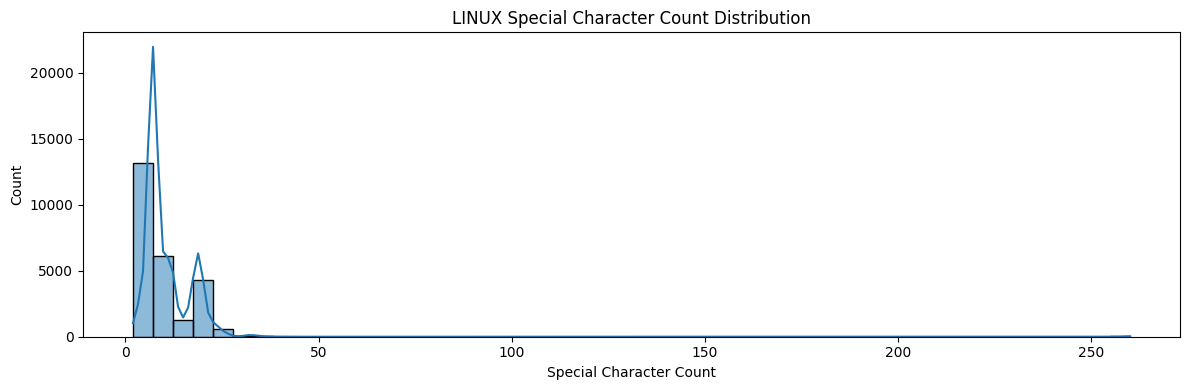


MAC Special Character Stats:
  Min: 0
  Max: 311
  Mean: 17.10
  Std: 14.08


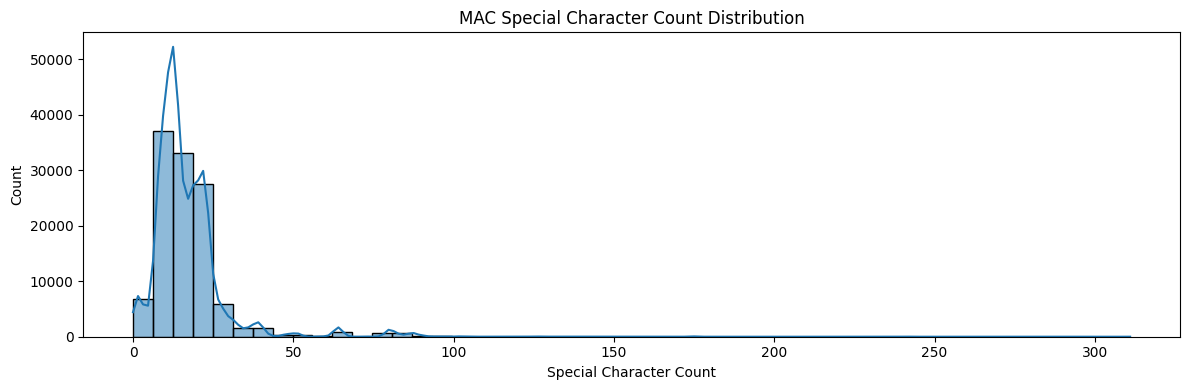

In [83]:
import string

def explore_special_characters(logs, name):
    special_counts = [sum(1 for c in line if c not in string.ascii_letters + string.digits + " ") for line in logs]
    print(f"\n{name} Special Character Stats:")
    print(f"  Min: {min(special_counts) if special_counts else 0}")
    print(f"  Max: {max(special_counts) if special_counts else 0}")
    print(f"  Mean: {np.mean(special_counts) if special_counts else 0:.2f}")
    print(f"  Std: {np.std(special_counts) if special_counts else 0:.2f}")
    plt.figure(figsize=(12, 4))
    sns.histplot(special_counts, bins=50, kde=True)
    plt.title(f"{name} Special Character Count Distribution")
    plt.xlabel("Special Character Count")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_special_chars.png")
    plt.show()

# Example usage:
explore_special_characters(hdfs_logs, "HDFS")
explore_special_characters(apache_logs,'APACHE')
explore_special_characters(bgl_logs, "BGL")
explore_special_characters(healthapp_logs, "HEALTHAPP")
explore_special_characters(hpc_logs, "HPC")
explore_special_characters(linux_logs, "LINUX")
explore_special_characters(mac_logs, "MAC")

### Unique Component Analysis

We count the number of unique components referenced in the logs.  
A high number of unique components may indicate a complex or distributed system, while a low number may suggest a focused or monolithic system.

In [84]:
def unique_component_count(logs, name):
    # Use the same extraction logic as your component diversity function
    patterns = [
        r'\[(.*?)\]', r'^([A-Za-z0-9_-]+):', r'(?:INFO|ERROR|WARN)\s+([^:]+):',
        r'\(([\w.-]+)\)', r'(?:daemon|server|client)\s+([\w.-]+)', r'blk_[-\d]+',
        r'BP-[\d\-]+', r'DFSClient_[\w.-]+', r'NameNode', r'DataNode',
        r'FSNamesystem', r'PacketResponder'
    ]
    components = set()
    for log in logs:
        for pattern in patterns:
            found = re.findall(pattern, log)
            if found:
                if isinstance(found, list):
                    components.update([comp for comp in found if comp])
                else:
                    components.add(found)
    print(f"{name}: {len(components)} unique components found.")

# Example usage:
unique_component_count(hdfs_logs, "HDFS")
unique_component_count(apache_logs,'APACHE')
unique_component_count(bgl_logs, "BGL")
unique_component_count(healthapp_logs, "HEALTHAPP")
unique_component_count(hpc_logs, "HPC")
unique_component_count(linux_logs, "LINUX")
unique_component_count(mac_logs, "MAC")


HDFS: 2210 unique components found.
APACHE: 25842 unique components found.
BGL: 179404 unique components found.
HEALTHAPP: 249 unique components found.
HPC: 2195 unique components found.
LINUX: 7959 unique components found.
MAC: 9590 unique components found.


### Numerical Value Extraction

We extract and analyze numerical values from log entries.  
This can reveal the presence of error codes, response times, memory usage, or other quantitative metrics embedded in the logs.


HDFS Numerical Value Stats:
  Min: 4
  Max: 106
  Mean: 7.54
  Std: 3.56


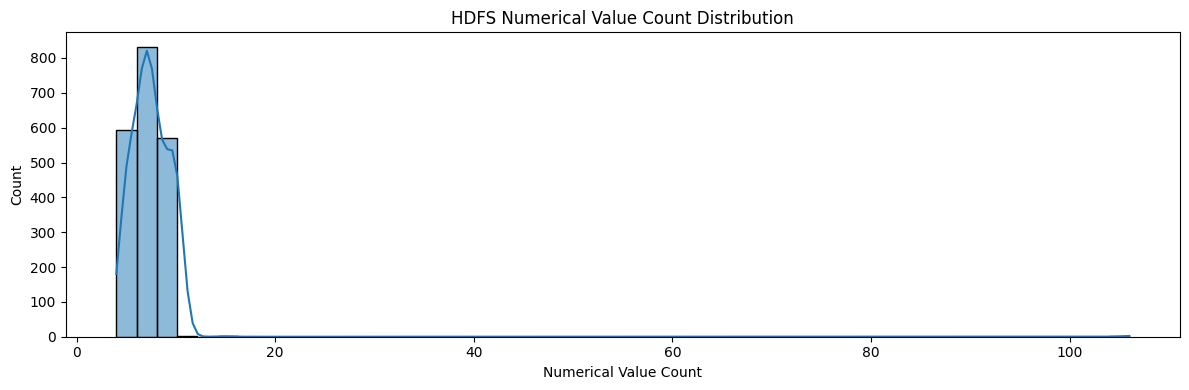


APACHE Numerical Value Stats:
  Min: 0
  Max: 14
  Mean: 6.36
  Std: 1.96


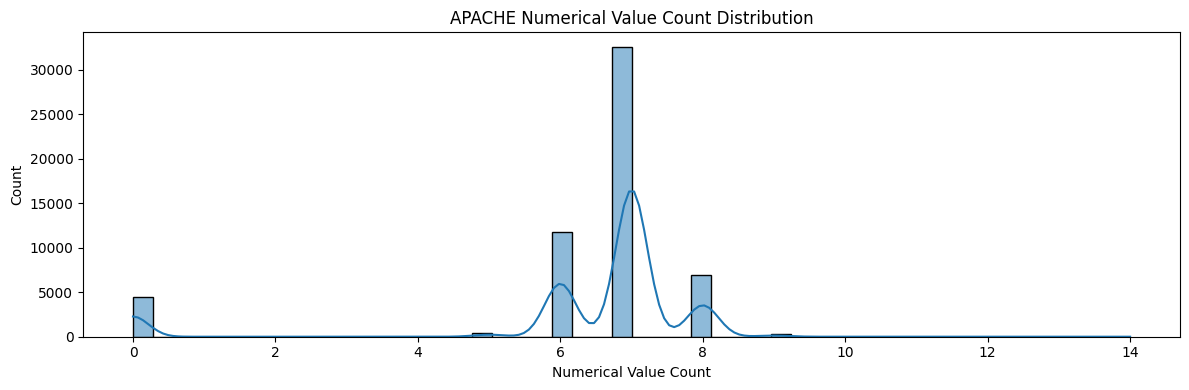


BGL Numerical Value Stats:
  Min: 8
  Max: 90
  Mean: 19.28
  Std: 4.85


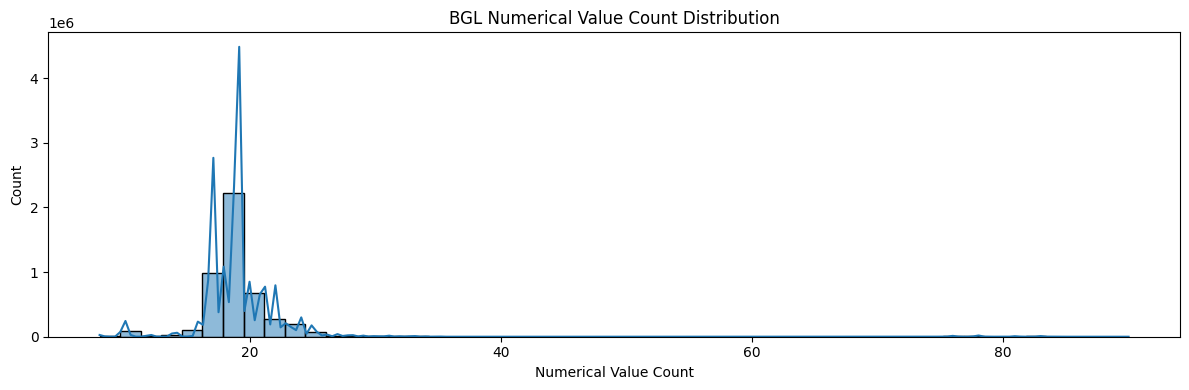


HEALTHAPP Numerical Value Stats:
  Min: 6
  Max: 24
  Mean: 8.92
  Std: 2.18


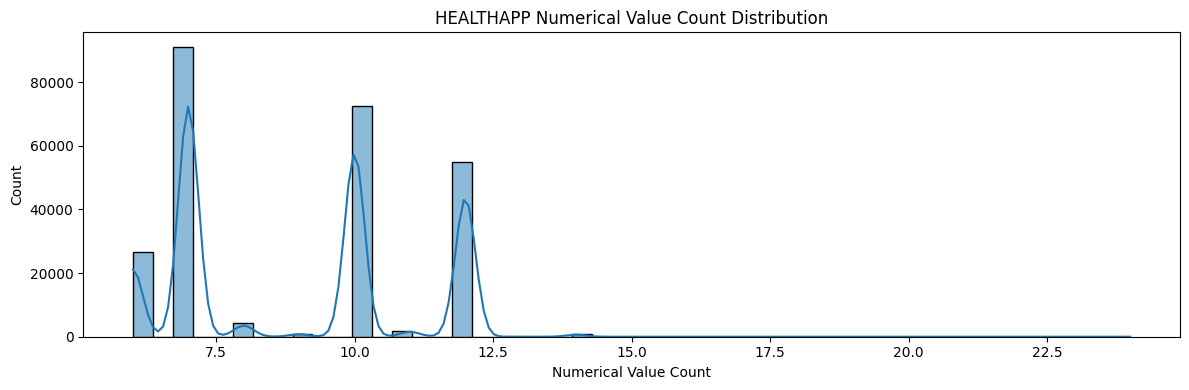


HPC Numerical Value Stats:
  Min: 3
  Max: 127
  Mean: 5.17
  Std: 2.18


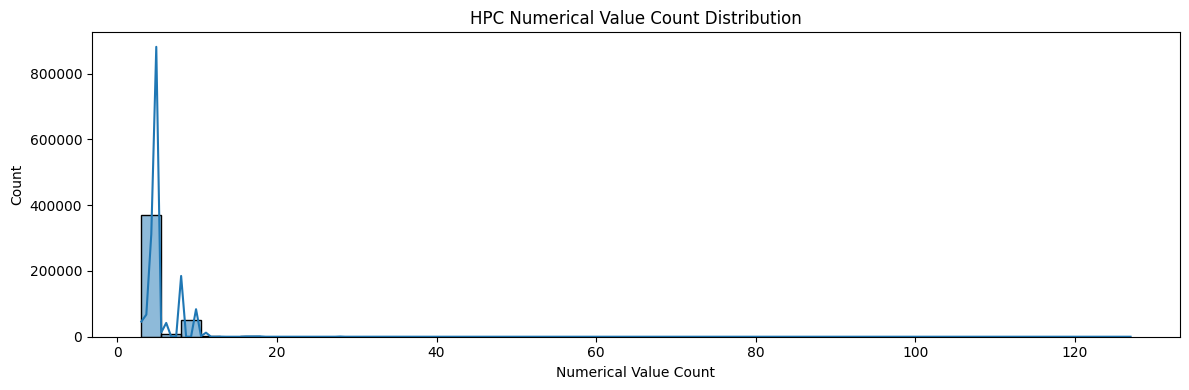


LINUX Numerical Value Stats:
  Min: 4
  Max: 241
  Mean: 7.47
  Std: 7.42


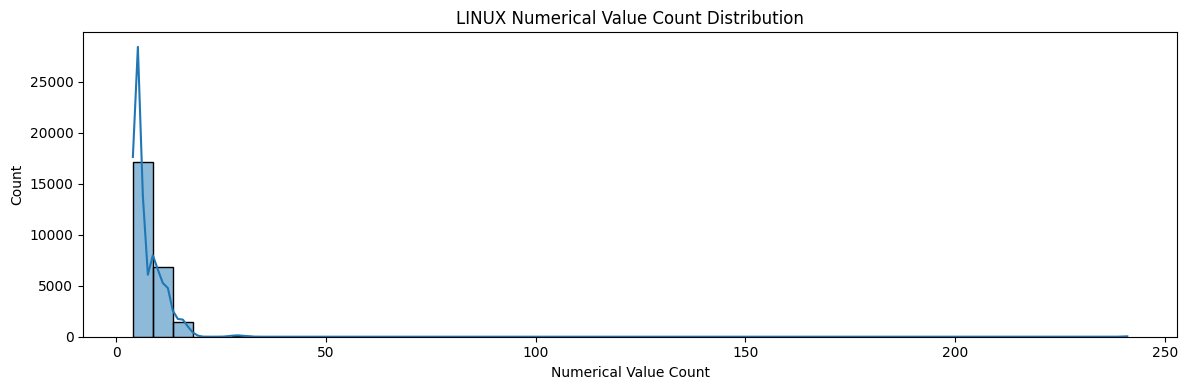


MAC Numerical Value Stats:
  Min: 0
  Max: 105
  Mean: 10.81
  Std: 6.19


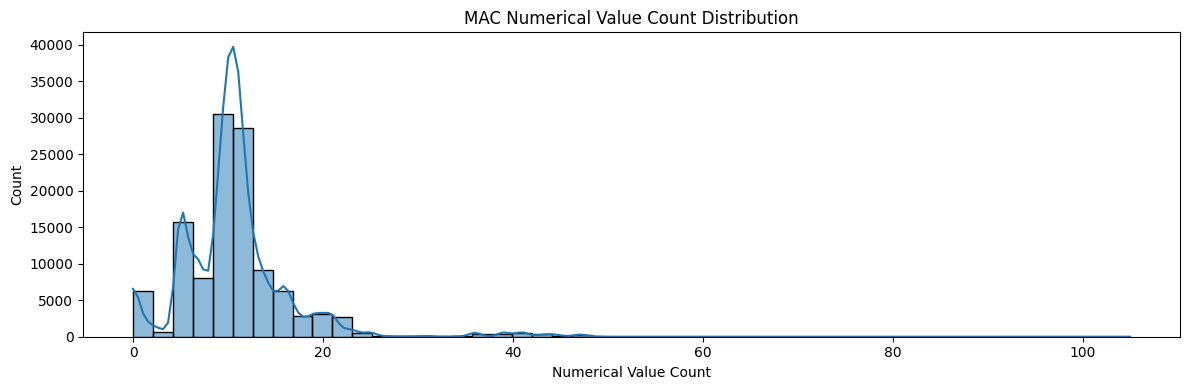

In [86]:
def extract_numerical_values(message):
    return [float(num) for num in re.findall(r'\d+(?:\.\d+)?', message)]

def analyze_numerical_values(logs, name):
    num_counts = [len(extract_numerical_values(line)) for line in logs]
    print(f"\n{name} Numerical Value Stats:")
    print(f"  Min: {min(num_counts) if num_counts else 0}")
    print(f"  Max: {max(num_counts) if num_counts else 0}")
    print(f"  Mean: {np.mean(num_counts) if num_counts else 0:.2f}")
    print(f"  Std: {np.std(num_counts) if num_counts else 0:.2f}")
    plt.figure(figsize=(12, 4))
    sns.histplot(num_counts, bins=50, kde=True)
    plt.title(f"{name} Numerical Value Count Distribution")
    plt.xlabel("Numerical Value Count")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_numerical_values.png")
    plt.show()

# Example usage:
analyze_numerical_values(hdfs_logs, "HDFS")
analyze_numerical_values(apache_logs,'APACHE')
analyze_numerical_values(bgl_logs, "BGL")
analyze_numerical_values(healthapp_logs, "HEALTHAPP")
analyze_numerical_values(hpc_logs, "HPC")
analyze_numerical_values(linux_logs, "LINUX")
analyze_numerical_values(mac_logs, "MAC")

### Burstiness and Inter-Arrival Time Analysis

We analyze the time between consecutive log entries (inter-arrival times) to detect bursty behavior, which may indicate incidents, attacks, or system overloads.

HDFS: Not enough timestamps for inter-arrival analysis.
APACHE: Not enough timestamps for inter-arrival analysis.
BGL: Not enough timestamps for inter-arrival analysis.

HEALTHAPP Inter-Arrival Time Stats:
  Min: 0.00 sec
  Max: 0.00 sec
  Mean: 0.00 sec
  Std: 0.00 sec


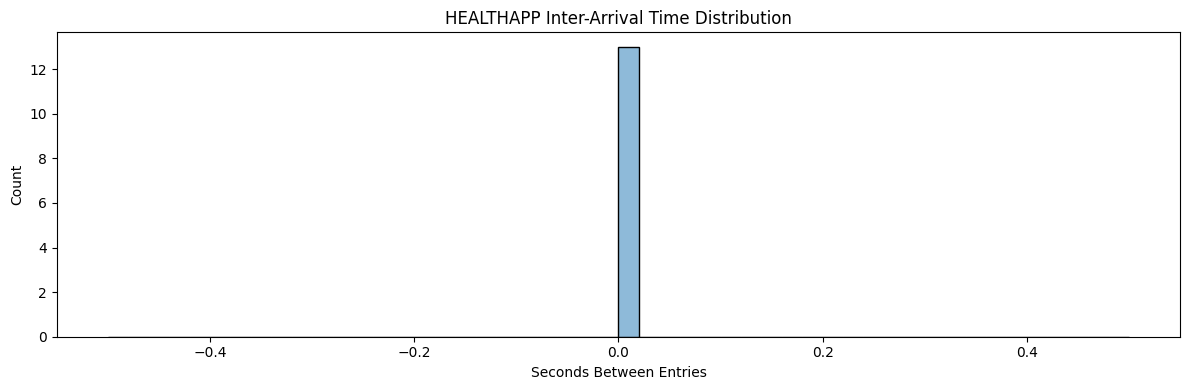

HPC: Not enough timestamps for inter-arrival analysis.
LINUX: Not enough timestamps for inter-arrival analysis.

MAC Inter-Arrival Time Stats:
  Min: 0.00 sec
  Max: 11472340.00 sec
  Mean: 5976.59 sec
  Std: 254935.83 sec


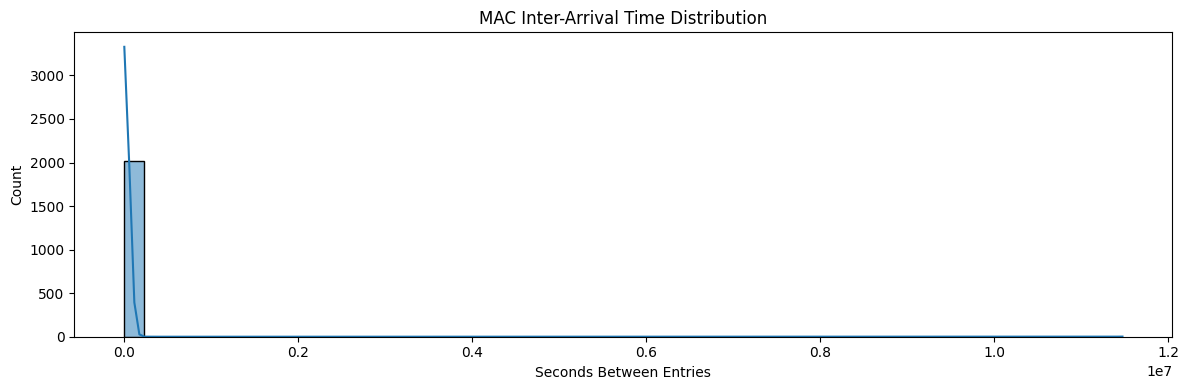

In [88]:
def analyze_interarrival_times(logs, name):
    # Use your timestamp extraction logic
    timestamp_patterns = [
        (r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y-%m-%d %H:%M:%S'),
        (r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2})', '%d/%b/%Y:%H:%M:%S')
        # Add more as needed
    ]
    timestamps = []
    for log in logs:
        for pattern, time_format in timestamp_patterns:
            match = re.search(pattern, log)
            if match:
                try:
                    timestamps.append(datetime.strptime(match.group(1), time_format))
                    break
                except ValueError:
                    continue
    timestamps.sort()
    if len(timestamps) > 1:
        interarrivals = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]
        print(f"\n{name} Inter-Arrival Time Stats:")
        print(f"  Min: {min(interarrivals):.2f} sec")
        print(f"  Max: {max(interarrivals):.2f} sec")
        print(f"  Mean: {np.mean(interarrivals):.2f} sec")
        print(f"  Std: {np.std(interarrivals):.2f} sec")
        plt.figure(figsize=(12, 4))
        sns.histplot(interarrivals, bins=50, kde=True)
        plt.title(f"{name} Inter-Arrival Time Distribution")
        plt.xlabel("Seconds Between Entries")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(plot_dir / f"{name.lower()}_interarrival_times.png")
        plt.show()
    else:
        print(f"{name}: Not enough timestamps for inter-arrival analysis.")

# Example usage:
analyze_interarrival_times(hdfs_logs, "HDFS")
analyze_interarrival_times(apache_logs,'APACHE')
analyze_interarrival_times(bgl_logs, "BGL")
analyze_interarrival_times(healthapp_logs, "HEALTHAPP")
analyze_interarrival_times(hpc_logs, "HPC")
analyze_interarrival_times(linux_logs, "LINUX")
analyze_interarrival_times(mac_logs, "MAC")

### Rare Message and Component Detection

We identify messages and components that appear very infrequently.  
Rare events may be indicative of anomalies, new behaviors, or system drift.

In [89]:
def detect_rare_components(logs, name, min_count=2):
    patterns = [
        r'\[(.*?)\]', r'^([A-Za-z0-9_-]+):', r'(?:INFO|ERROR|WARN)\s+([^:]+):',
        r'\(([\w.-]+)\)', r'(?:daemon|server|client)\s+([\w.-]+)', r'blk_[-\d]+',
        r'BP-[\d\-]+', r'DFSClient_[\w.-]+', r'NameNode', r'DataNode',
        r'FSNamesystem', r'PacketResponder'
    ]
    components = []
    for log in logs:
        for pattern in patterns:
            found = re.findall(pattern, log)
            if found:
                if isinstance(found, list):
                    components.extend([comp for comp in found if comp])
                else:
                    components.append(found)
    comp_counts = Counter(components)
    rare = [comp for comp, count in comp_counts.items() if count <= min_count]
    print(f"{name}: {len(rare)} rare components (appearing <= {min_count} times)")
    if rare:
        print("Sample rare components:", rare[:10])

# Example usage:
detect_rare_components(hdfs_logs, "HDFS")
detect_rare_components(apache_logs,'APACHE')
detect_rare_components(bgl_logs, "BGL")
detect_rare_components(healthapp_logs, "HEALTHAPP")
detect_rare_components(hpc_logs, "HPC")
detect_rare_components(linux_logs, "LINUX")
detect_rare_components(mac_logs, "MAC")

HDFS: 2201 rare components (appearing <= 2 times)
Sample rare components: ['blk_38865049064139660', 'blk_-6952295868487656571', 'blk_7128370237687728475', 'blk_8229193803249955061', 'blk_-6670958622368987959', 'blk_3050920587428079149', 'blk_7888946331804732825', 'blk_2377150260128098806', 'blk_572492839287299681', 'blk_3587508140051953248']
APACHE: 19953 rare components (appearing <= 2 times)
Sample rare components: ['Thu Jun 09 06:07:16 2005', 'Thu Jun 09 07:11:21 2005', 'Thu Jun 09 12:08:57 2005', 'Thu Jun 09 12:17:49 2005', 'client 216.68.171.39', '216.68.171.39', 'Thu Jun 09 12:48:10 2005', 'client 24.158.204.7', '24.158.204.7', 'Thu Jun 09 13:59:36 2005']
BGL: 178301 rare components (appearing <= 2 times)
Sample rare components: ['R33-M1-ND', '203231503833343000000000594c31304b35303034303232', '10.3.0.80', '10.3.1.25', '10.3.1.68', '10.0.0.121', '000000000000000000000000fff29f16e842000d60e917bd', '000000000000000000000000fff29f16eb54000d60e914ab', '000000000000000000000000fff29f1

### Log Entry Uniqueness

We measure the proportion of unique log entries.  
A high uniqueness ratio may indicate a noisy or highly variable system, while a low ratio may suggest repetitive or templated logging.

In [90]:
def analyze_uniqueness(logs, name):
    unique_count = len(set(logs))
    total_count = len(logs)
    print(f"{name}: {unique_count}/{total_count} unique entries ({(unique_count/total_count*100 if total_count else 0):.2f}%)")

# Example usage:
analyze_uniqueness(hdfs_logs, "HDFS")
analyze_uniqueness(apache_logs,'APACHE')
analyze_uniqueness(bgl_logs, "BGL")
analyze_uniqueness(healthapp_logs, "HEALTHAPP")
analyze_uniqueness(hpc_logs, "HPC")
analyze_uniqueness(linux_logs, "LINUX")
analyze_uniqueness(mac_logs, "MAC")

HDFS: 2000/2000 unique entries (100.00%)
APACHE: 28326/56482 unique entries (50.15%)
BGL: 4747959/4747963 unique entries (100.00%)
HEALTHAPP: 252979/253395 unique entries (99.84%)
HPC: 416673/433490 unique entries (96.12%)
LINUX: 25546/25567 unique entries (99.92%)
MAC: 95808/116735 unique entries (82.07%)


### Clustering Log Entries

We use unsupervised clustering to group similar log entries together.  
- This helps us discover common patterns, repetitive messages, and outliers.
- We use TF-IDF vectorization to convert log messages into numerical features, and KMeans to cluster them.
- Examining the largest and smallest clusters can reveal both dominant log types and rare, potentially anomalous messages.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

def cluster_log_entries(logs, name, n_clusters=5, random_state=42):
    """
    Cluster log entries using TF-IDF and KMeans.
    Prints the size of each cluster and sample messages from each.
    """
    if not logs:
        print(f"No logs to cluster for {name}.")
        return

    # Vectorize log messages
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(logs)

    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X)

    # Analyze clusters
    print(f"\n{name} Clustering Results (k={n_clusters}):")
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        print(f"\nCluster {i} - Size: {len(cluster_indices)}")
        # Show up to 3 sample messages from each cluster
        for idx in cluster_indices[:3]:
            print(f"  - {logs[idx][:100]}{'...' if len(logs[idx]) > 100 else ''}")

    # Optionally, plot cluster sizes
    plt.figure(figsize=(8, 4))
    plt.bar(range(n_clusters), [np.sum(labels == i) for i in range(n_clusters)])
    plt.title(f"{name} Log Entry Cluster Sizes")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Entries")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_cluster_sizes.png")
    plt.show()

# Example usage:
cluster_log_entries(hdfs_logs, "HDFS", n_clusters=5)
cluster_log_entries(apache_logs,'APACHE' , n_clusters=5)
cluster_log_entries(bgl_logs, "BGL" , n_clusters=5)
cluster_log_entries(healthapp_logs, "HEALTHAPP" , n_clusters=5)
cluster_log_entries(hpc_logs, "HPC" , n_clusters=5)
cluster_log_entries(linux_logs, "LINUX" , n_clusters=5)
cluster_log_entries(mac_logs, "MAC" , n_clusters=5)

### Clustering with DBSCAN

We use DBSCAN, a density-based clustering algorithm, to group log entries and identify outliers.  
DBSCAN can automatically detect noise points (potential anomalies) that do not belong to any cluster.


HDFS DBSCAN Clustering Results:
Clusters found: 3
Noise points (potential anomalies): 272

Cluster 0 - Size: 1593
  - 081109 203615 148 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_388650490641396...
  - 081109 203807 222 INFO dfs.DataNode$PacketResponder: PacketResponder 0 for block blk_-69522958684876...
  - 081109 204005 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.7...

Cluster 1 - Size: 115
  - 081109 205035 28 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /user/root/rand/_temporary/...
  - 081109 205315 29 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /user/root/rand/_temporary/...
  - 081109 205858 31 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /user/root/rand/_temporary/...

Cluster 2 - Size: 20
  - 081109 205931 13 INFO dfs.DataBlockScanner: Verification succeeded for blk_-4980916519894289629
  - 081109 213436 13 INFO dfs.DataBlockScanner: Verification succeeded for blk_-282771623897

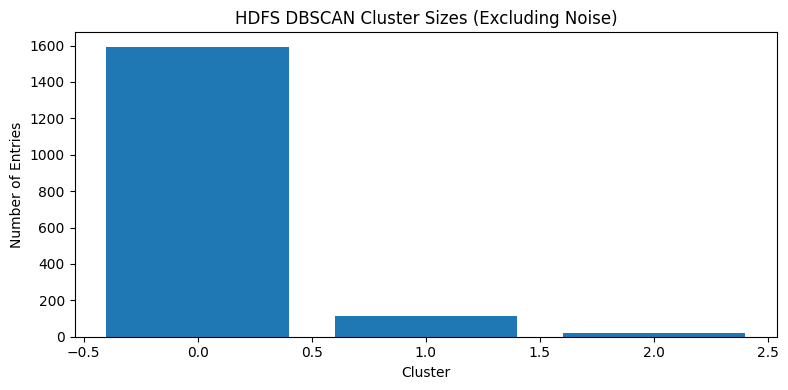


APACHE DBSCAN Clustering Results:
Clusters found: 73
Noise points (potential anomalies): 32

Cluster 0 - Size: 106
  - [Thu Jun 09 06:07:04 2005] [notice] LDAP: Built with OpenLDAP LDAP SDK
  - [Thu Jun 09 06:07:04 2005] [notice] LDAP: SSL support unavailable
  - [Thu Jun 09 06:07:05 2005] [notice] LDAP: Built with OpenLDAP LDAP SDK

Cluster 1 - Size: 8
  - [Thu Jun 09 06:07:04 2005] [notice] suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)
  - [Fri Jun 10 11:32:26 2005] [notice] suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)
  - [Wed Jul 27 14:42:39 2005] [notice] suEXEC mechanism enabled (wrapper: /usr/sbin/suexec)

Cluster 2 - Size: 49696
  - [Thu Jun 09 06:07:05 2005] [notice] Digest: generating secret for digest authentication ...
  - [Thu Jun 09 06:07:05 2005] [notice] Digest: done
  - [Thu Jun 09 06:07:05 2005] [error] env.createBean2(): Factory error creating channel.jni:jni ( chann...

Cluster 3 - Size: 45
  - [Thu Jun 09 06:07:16 2005] [notice] mod_python: Creating

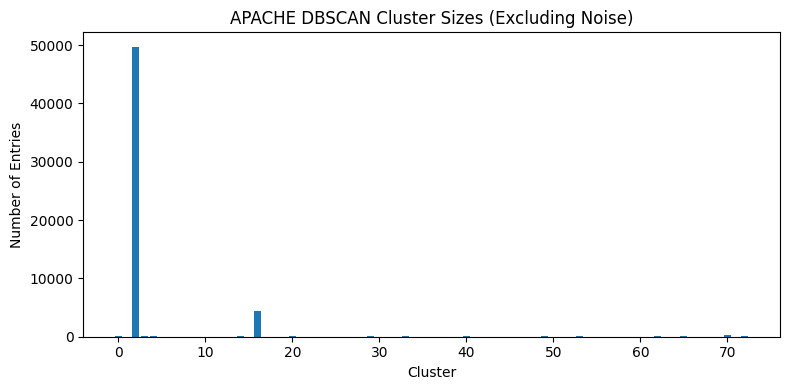

In [ ]:
from sklearn.cluster import DBSCAN

def cluster_log_entries_dbscan(logs, name, eps=0.5, min_samples=5):
    if not logs:
        print(f"No logs to cluster for {name}.")
        return
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(logs)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = dbscan.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"\n{name} DBSCAN Clustering Results:")
    print(f"Clusters found: {n_clusters}")
    print(f"Noise points (potential anomalies): {n_noise}")
    for i in set(labels):
        if i == -1:
            continue
        cluster_indices = np.where(labels == i)[0]
        print(f"\nCluster {i} - Size: {len(cluster_indices)}")
        for idx in cluster_indices[:3]:
            print(f"  - {logs[idx][:100]}{'...' if len(logs[idx]) > 100 else ''}")
    cluster_sizes = [np.sum(labels == i) for i in set(labels) if i != -1]
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(cluster_sizes)), cluster_sizes)
    plt.title(f"{name} DBSCAN Cluster Sizes (Excluding Noise)")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Entries")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_dbscan_cluster_sizes.png")
    plt.show()
cluster_log_entries_dbscan(hdfs_logs, "HDFS", eps=0.5, min_samples=5)
cluster_log_entries_dbscan(apache_logs,'APACHE' , eps=0.5, min_samples=5)
cluster_log_entries_dbscan(bgl_logs, "BGL", eps=0.5, min_samples=5)
cluster_log_entries_dbscan(healthapp_logs, "HEALTHAPP" , eps=0.5, min_samples=5)
cluster_log_entries_dbscans(hpc_logs, "HPC" ,eps=0.5, min_samples=5)
cluster_log_entries_dbscan(linux_logs, "LINUX" , eps=0.5, min_samples=5)
cluster_log_entries_dbscan(mac_logs, "MAC" , eps=0.5, min_samples=5)
    

### Hierarchical Clustering

We use agglomerative hierarchical clustering to explore the relationships between log entries.  
A dendrogram can help visualize how clusters are formed at different similarity thresholds.

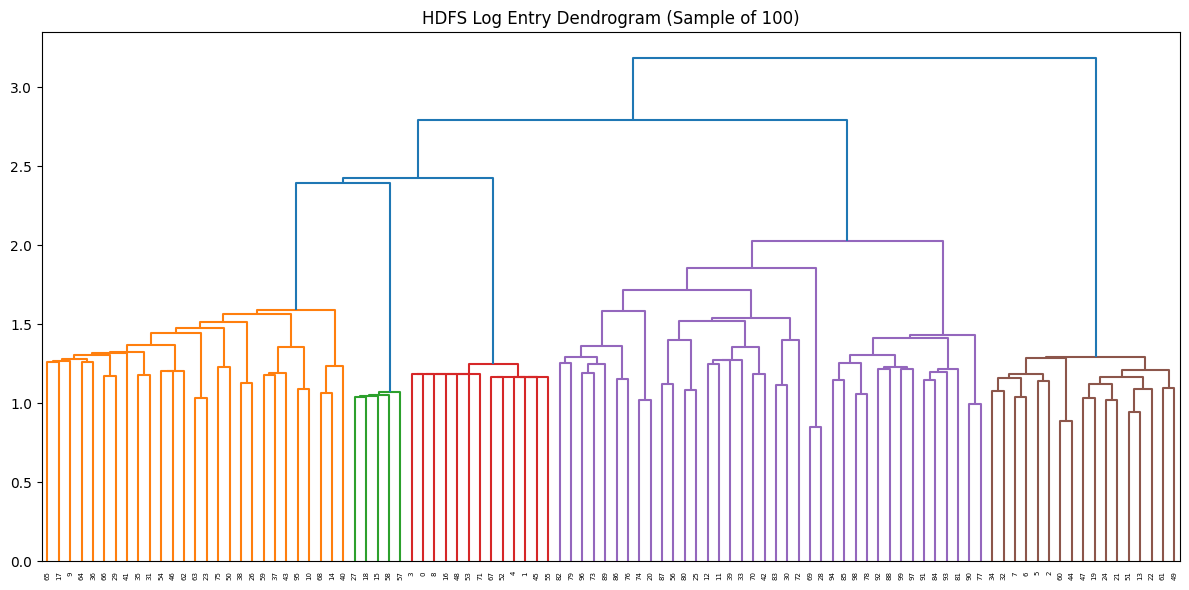

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(logs, name, sample_size=100):
    sample_logs = logs[:sample_size]
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(sample_logs).toarray()
    linked = linkage(X, 'ward')
    plt.figure(figsize=(12, 6))
    dendrogram(linked, orientation='top', labels=[f"{i}" for i in range(len(sample_logs))], distance_sort='descending', show_leaf_counts=True)
    plt.title(f"{name} Log Entry Dendrogram (Sample of {sample_size})")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_dendrogram.png")
    plt.show()
plot_dendrogram(hdfs_logs, "HDFS", sample_size=100)
plot_dendrogram(apache_logs,'APACHE' , sample_size=100)
plot_dendrogram(bgl_logs, "BGL",  sample_size=100)
plot_dendrogram(healthapp_logs, "HEALTHAPP" ,  sample_size=100)
plot_dendrogram(hpc_logs, "HPC" , sample_size=100)
plot_dendrogram(linux_logs, "LINUX" , sample_size=100)
plot_dendrogram(mac_logs, "MAC" ,  sample_size=100)
    

### t-SNE Visualization of Log Entry Clusters

We use t-SNE to project high-dimensional log entry features into 2D for visualization.  
This helps us visually assess the separation and structure of clusters.

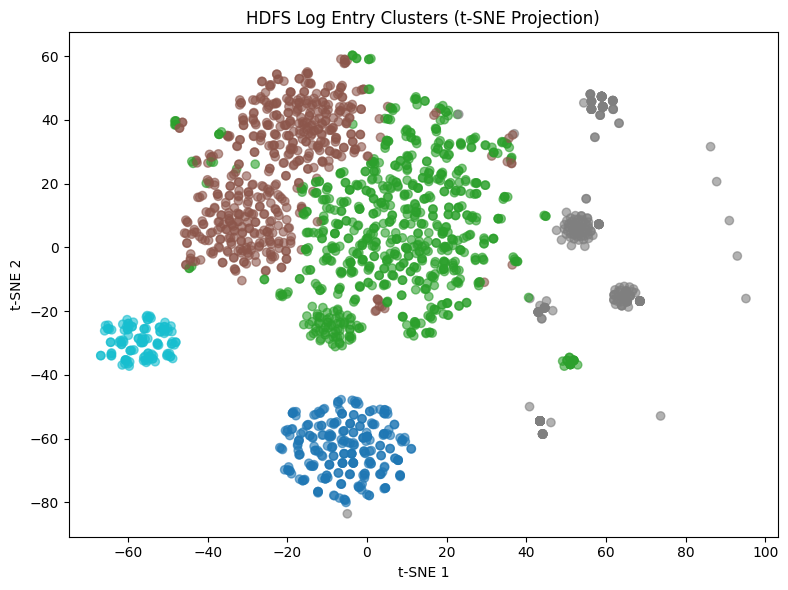

In [64]:
from sklearn.manifold import TSNE

def plot_tsne(logs, name, n_clusters=5):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(logs)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X.toarray())
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.title(f"{name} Log Entry Clusters (t-SNE Projection)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.savefig(plot_dir / f"{name.lower()}_tsne_clusters.png")
    plt.show()
plot_tsne(hdfs_logs, "HDFS", n_clusters=5)
plot_tsne(apache_logs,'APACHE' ,  n_clusters=5)
plot_tsne(bgl_logs, "BGL",   n_clusters=5)
plot_tsne(healthapp_logs, "HEALTHAPP" ,   n_clusters=5)
plot_tsne(hpc_logs, "HPC" ,  n_clusters=5)
plot_tsne(linux_logs, "LINUX" , n_clusters=5)
plot_tsne(mac_logs, "MAC" ,   n_clusters=5)

NameError: name 'cluster_log_entries_kmeans' is not defined